In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import cv2
from scipy.signal import find_peaks

## Read in the family information and sample submission

In [2]:
fpath = 'family_data.csv'
data = pd.read_csv(fpath, index_col='family_id')

fpath = 'sample_submission.csv'
submission = pd.read_csv(fpath, index_col='family_id')

In [5]:
data.shape

(5000, 11)

In [14]:
data["n_people"].sum() / 100

210.03

In [16]:
data["choice_0"].min()

1

## Create some lookup dictionaries and define constants

You don't need to do it this way. :-)

In [3]:
family_size_dict = data[['n_people']].to_dict()['n_people']

cols = [f'choice_{i}' for i in range(10)]
choice_dict = data[cols].to_dict()

N_DAYS = 100

MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125

# from 100 to 1
days = list(range(N_DAYS,0,-1))

## Cost Function
Very un-optimized  ;-)

In [4]:
def cost_function(prediction):

    penalty = 0

    # We'll use this to count the number of people scheduled each day
    daily_occupancy = {k:0 for k in days}
    
    # Looping over each family; d is the day for each family f
    for f, d in enumerate(prediction):

        # Using our lookup dictionaries to make simpler variable names
        n = family_size_dict[f]
        choice_0 = choice_dict['choice_0'][f]
        choice_1 = choice_dict['choice_1'][f]
        choice_2 = choice_dict['choice_2'][f]
        choice_3 = choice_dict['choice_3'][f]
        choice_4 = choice_dict['choice_4'][f]
        choice_5 = choice_dict['choice_5'][f]
        choice_6 = choice_dict['choice_6'][f]
        choice_7 = choice_dict['choice_7'][f]
        choice_8 = choice_dict['choice_8'][f]
        choice_9 = choice_dict['choice_9'][f]

        # add the family member count to the daily occupancy
        daily_occupancy[d] += n

        # Calculate the penalty for not getting top preference
        if d == choice_0:
            penalty += 0
        elif d == choice_1:
            penalty += 50
        elif d == choice_2:
            penalty += 50 + 9 * n
        elif d == choice_3:
            penalty += 100 + 9 * n
        elif d == choice_4:
            penalty += 200 + 9 * n
        elif d == choice_5:
            penalty += 200 + 18 * n
        elif d == choice_6:
            penalty += 300 + 18 * n
        elif d == choice_7:
            penalty += 300 + 36 * n
        elif d == choice_8:
            penalty += 400 + 36 * n
        elif d == choice_9:
            penalty += 500 + 36 * n + 199 * n
        else:
            penalty += 500 + 36 * n + 398 * n

    # for each date, check total occupancy
    #  (using soft constraints instead of hard constraints)
    for _, v in daily_occupancy.items():
        if (v > MAX_OCCUPANCY) or (v < MIN_OCCUPANCY):
            penalty += 100000000

    # Calculate the accounting cost
    # The first day (day 100) is treated special
    accounting_cost = (daily_occupancy[days[0]]-125.0) / 400.0 * daily_occupancy[days[0]]**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = daily_occupancy[days[0]]
    for day in days[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        accounting_cost += max(0, (daily_occupancy[day]-125.0) / 400.0 * daily_occupancy[day]**(0.5 + diff / 50.0))
        yesterday_count = today_count
        
    print("pref/acc: %d/%d" % (penalty, accounting_cost))
        
    penalty += accounting_cost

    return penalty

## Simple Opimization Approach

For each family, loop over their choices, and if keep it if the score improves. There's a lot of easy improvement that can be made to this code.

In [5]:
# Start with the sample submission values
best = submission['assigned_day'].tolist()
start_score = cost_function(best)

new = best.copy()
# loop over each family
for fam_id, _ in enumerate(best):
    # loop over each family choice
    for pick in range(10):
        day = choice_dict[f'choice_{pick}'][fam_id]
        temp = new.copy()
        temp[fam_id] = day # add in the new pick
        if cost_function(temp) < start_score:
            new = temp.copy()
            start_score = cost_function(new)

submission['assigned_day'] = new
score = cost_function(new)
submission.to_csv(f'submission_{score}.csv')
print(f'Score: {score}')

pref/acc: 10639591/1907
pref/acc: 10637355/1898
pref/acc: 10637355/1898
pref/acc: 10637405/1908
pref/acc: 10637441/1888
pref/acc: 10637491/1894
pref/acc: 10637591/1845
pref/acc: 10637627/1899
pref/acc: 10637727/1916
pref/acc: 10637799/1909
pref/acc: 10637899/1972
pref/acc: 10638795/1958
pref/acc: 10635119/1918
pref/acc: 10635119/1918
pref/acc: 10635169/1905
pref/acc: 10635205/1890
pref/acc: 10635255/1932
pref/acc: 10635355/1915
pref/acc: 10635391/1893
pref/acc: 10635491/1904
pref/acc: 10635563/1885
pref/acc: 10635663/1910
pref/acc: 10636559/1937
pref/acc: 10633317/1916
pref/acc: 10633317/1916
pref/acc: 10633367/1917
pref/acc: 10633394/1911
pref/acc: 10633444/1900
pref/acc: 10633544/1895
pref/acc: 10633571/1905
pref/acc: 10633671/1960
pref/acc: 10633725/1921
pref/acc: 10633825/1890
pref/acc: 10634522/1866
pref/acc: 10631949/1967
pref/acc: 10631949/1967
pref/acc: 10631999/1928
pref/acc: 10632017/1932
pref/acc: 10632067/1990
pref/acc: 10632167/1989
pref/acc: 10632185/1931
pref/acc: 106322

pref/acc: 10569857/1654
pref/acc: 10569857/1654
pref/acc: 10569907/1652
pref/acc: 10569934/1653
pref/acc: 10569984/1657
pref/acc: 10570084/1636
pref/acc: 10570111/1683
pref/acc: 10570211/1639
pref/acc: 10570265/1699
pref/acc: 10570365/1652
pref/acc: 10571062/1685
pref/acc: 10568055/1703
pref/acc: 10568055/1703
pref/acc: 10568105/1717
pref/acc: 10568132/1653
pref/acc: 10568182/1663
pref/acc: 10568282/1661
pref/acc: 10568309/1686
pref/acc: 10568409/1639
pref/acc: 10568463/1680
pref/acc: 10568563/1668
pref/acc: 10569260/1666
pref/acc: 10566253/1725
pref/acc: 10566253/1725
pref/acc: 10566303/1696
pref/acc: 10566330/1690
pref/acc: 10566380/1714
pref/acc: 10566480/1699
pref/acc: 10566507/1694
pref/acc: 10566607/1690
pref/acc: 10566661/1687
pref/acc: 10566761/1665
pref/acc: 10567458/1694
pref/acc: 10565845/1733
pref/acc: 10565845/1733
pref/acc: 10565895/1730
pref/acc: 10565922/1735
pref/acc: 10565972/1755
pref/acc: 10566072/1735
pref/acc: 10566099/1730
pref/acc: 10566199/1714
pref/acc: 105662

pref/acc: 10519564/1664
pref/acc: 10514984/1709
pref/acc: 10514984/1709
pref/acc: 10515034/1636
pref/acc: 10515034/1636
pref/acc: 10515079/1661
pref/acc: 10515129/1676
pref/acc: 10515229/1677
pref/acc: 10515274/1650
pref/acc: 10515374/1658
pref/acc: 10515464/1671
pref/acc: 10515564/1655
pref/acc: 10516659/1650
pref/acc: 10513232/1619
pref/acc: 10513232/1619
pref/acc: 10513282/1617
pref/acc: 10513309/1626
pref/acc: 10513359/1612
pref/acc: 10513459/1640
pref/acc: 10513486/1658
pref/acc: 10513586/1676
pref/acc: 10513640/1629
pref/acc: 10513740/1655
pref/acc: 10514437/1632
pref/acc: 10510562/1623
pref/acc: 10510562/1623
pref/acc: 10510612/1625
pref/acc: 10510657/1632
pref/acc: 10510707/1644
pref/acc: 10510807/1653
pref/acc: 10510852/1632
pref/acc: 10510952/1618
pref/acc: 10511042/1593
pref/acc: 10511142/1609
pref/acc: 10512237/1622
pref/acc: 10506590/1619
pref/acc: 10506590/1619
pref/acc: 10506640/1641
pref/acc: 10506712/1609
pref/acc: 10506762/1665
pref/acc: 10506862/1637
pref/acc: 105069

pref/acc: 10444251/1780
pref/acc: 10444351/1737
pref/acc: 10445247/1724
pref/acc: 10442005/1736
pref/acc: 10442005/1736
pref/acc: 10442055/1717
pref/acc: 10442082/1712
pref/acc: 10442132/1725
pref/acc: 10442232/1753
pref/acc: 10442259/1735
pref/acc: 10442359/1743
pref/acc: 10442413/1732
pref/acc: 10442513/1755
pref/acc: 10443210/1721
pref/acc: 10438901/1769
pref/acc: 10438901/1769
pref/acc: 10438951/1852
pref/acc: 10439005/1682
pref/acc: 10439055/1744
pref/acc: 10439155/1738
pref/acc: 10439209/1739
pref/acc: 10439309/1734
pref/acc: 10439417/1761
pref/acc: 10439517/1730
pref/acc: 10440811/1755
pref/acc: 10437533/1771
pref/acc: 10437533/1771
pref/acc: 10437583/1806
pref/acc: 10437601/1789
pref/acc: 10437651/1766
pref/acc: 10437751/1769
pref/acc: 10437769/1760
pref/acc: 10437869/1773
pref/acc: 10437905/1775
pref/acc: 10438005/1771
pref/acc: 10438503/1783
pref/acc: 10433995/1838
pref/acc: 10433995/1838
pref/acc: 10434045/1745
pref/acc: 10434045/1745
pref/acc: 10434108/1783
pref/acc: 104341

pref/acc: 10360017/1833
pref/acc: 10360017/1833
pref/acc: 10360067/1798
pref/acc: 10360103/1833
pref/acc: 10360153/1809
pref/acc: 10360253/1887
pref/acc: 10360289/1822
pref/acc: 10360389/1857
pref/acc: 10360461/1821
pref/acc: 10360561/1886
pref/acc: 10361457/1826
pref/acc: 10356045/1802
pref/acc: 10356045/1802
pref/acc: 10356095/2107
pref/acc: 10356167/1861
pref/acc: 10356217/1927
pref/acc: 10356317/1797
pref/acc: 10356389/1836
pref/acc: 10356489/1834
pref/acc: 10356633/1827
pref/acc: 10356733/1778
pref/acc: 10358425/1875
pref/acc: 10352941/1925
pref/acc: 10352941/1925
pref/acc: 10352991/1765
pref/acc: 10352991/1765
pref/acc: 10353045/1804
pref/acc: 10353095/1836
pref/acc: 10353195/1811
pref/acc: 10353249/1859
pref/acc: 10353349/1862
pref/acc: 10353457/1813
pref/acc: 10353557/1816
pref/acc: 10354851/1797
pref/acc: 10351189/1761
pref/acc: 10351189/1761
pref/acc: 10351239/1762
pref/acc: 10351266/1744
pref/acc: 10351316/1763
pref/acc: 10351416/1754
pref/acc: 10351443/1758
pref/acc: 103515

pref/acc: 10288424/1930
pref/acc: 10288524/1927
pref/acc: 10288596/1910
pref/acc: 10288696/1921
pref/acc: 10289592/1926
pref/acc: 10285916/1939
pref/acc: 10285916/1939
pref/acc: 10285966/1939
pref/acc: 10286002/1964
pref/acc: 10286052/1932
pref/acc: 10286152/1945
pref/acc: 10286188/1942
pref/acc: 10286288/2019
pref/acc: 10286360/1947
pref/acc: 10286460/1943
pref/acc: 10287356/1979
pref/acc: 10283680/1905
pref/acc: 10283680/1905
pref/acc: 10283730/1900
pref/acc: 10283766/1917
pref/acc: 10283816/1976
pref/acc: 10283916/1907
pref/acc: 10283952/1918
pref/acc: 10284052/1926
pref/acc: 10284124/1913
pref/acc: 10284224/1939
pref/acc: 10285120/1946
pref/acc: 10281010/1874
pref/acc: 10281010/1874
pref/acc: 10281060/1898
pref/acc: 10281105/1878
pref/acc: 10281155/1967
pref/acc: 10281255/1889
pref/acc: 10281300/1853
pref/acc: 10281400/1893
pref/acc: 10281490/1866
pref/acc: 10281590/1857
pref/acc: 10282685/1880
pref/acc: 10277472/1878
pref/acc: 10277472/1878
pref/acc: 10277522/1916
pref/acc: 102775

pref/acc: 10179808/2007
pref/acc: 10179908/1972
pref/acc: 10179935/1919
pref/acc: 10180035/1959
pref/acc: 10180089/1955
pref/acc: 10180189/1952
pref/acc: 10180886/1952
pref/acc: 10179577/1937
pref/acc: 10179577/1937
pref/acc: 10179627/2007
pref/acc: 10179681/1961
pref/acc: 10179731/1920
pref/acc: 10179831/1960
pref/acc: 10179885/1873
pref/acc: 10179985/1946
pref/acc: 10180093/1922
pref/acc: 10180193/1924
pref/acc: 10181487/1945
pref/acc: 10178209/1982
pref/acc: 10178209/1982
pref/acc: 10178259/1955
pref/acc: 10178277/1949
pref/acc: 10178327/1949
pref/acc: 10178427/1945
pref/acc: 10178445/1924
pref/acc: 10178545/1948
pref/acc: 10178581/1959
pref/acc: 10178681/1981
pref/acc: 10179179/1962
pref/acc: 10175539/1998
pref/acc: 10175539/1998
pref/acc: 10175589/1944
pref/acc: 10175589/1944
pref/acc: 10175634/1993
pref/acc: 10175684/2028
pref/acc: 10175784/2023
pref/acc: 10175829/1951
pref/acc: 10175929/2089
pref/acc: 10176019/1979
pref/acc: 10176119/1973
pref/acc: 10177214/1979
pref/acc: 101737

pref/acc: 10100005/1907
pref/acc: 10100105/1901
pref/acc: 10100213/1888
pref/acc: 10100313/1912
pref/acc: 10101607/2011
pref/acc: 10097461/1919
pref/acc: 10097461/1919
pref/acc: 10097511/1917
pref/acc: 10097547/1895
pref/acc: 10097597/1923
pref/acc: 10097697/1946
pref/acc: 10097733/1922
pref/acc: 10097833/1936
pref/acc: 10097905/1974
pref/acc: 10098005/1933
pref/acc: 10098901/1947
pref/acc: 10094791/1927
pref/acc: 10094791/1927
pref/acc: 10094841/1912
pref/acc: 10094886/1980
pref/acc: 10094936/1910
pref/acc: 10095036/1918
pref/acc: 10095081/2042
pref/acc: 10095181/1914
pref/acc: 10095271/1904
pref/acc: 10095371/1911
pref/acc: 10096466/1926
pref/acc: 10092121/1935
pref/acc: 10092121/1935
pref/acc: 10092171/1928
pref/acc: 10092216/1949
pref/acc: 10092266/1944
pref/acc: 10092366/1968
pref/acc: 10092411/1931
pref/acc: 10092511/1971
pref/acc: 10092601/1920
pref/acc: 10092701/1933
pref/acc: 10093796/2005
pref/acc: 10090319/1924
pref/acc: 10090319/1924
pref/acc: 10090369/1929
pref/acc: 100903

pref/acc: 10015451/2116
pref/acc: 10015501/2288
pref/acc: 10015573/2154
pref/acc: 10015623/2110
pref/acc: 10015723/2091
pref/acc: 10015795/2099
pref/acc: 10015895/2102
pref/acc: 10016039/2083
pref/acc: 10016139/2114
pref/acc: 10017831/2127
pref/acc: 10013649/2134
pref/acc: 10013649/2134
pref/acc: 10013699/2122
pref/acc: 10013726/2135
pref/acc: 10013776/2101
pref/acc: 10013876/2137
pref/acc: 10013903/2142
pref/acc: 10014003/2113
pref/acc: 10014057/2120
pref/acc: 10014157/2130
pref/acc: 10014854/2113
pref/acc: 10011847/2092
pref/acc: 10011847/2092
pref/acc: 10011897/2116
pref/acc: 10011924/2187
pref/acc: 10011974/2151
pref/acc: 10012074/2136
pref/acc: 10012101/2114
pref/acc: 10012201/2125
pref/acc: 10012255/2131
pref/acc: 10012355/2110
pref/acc: 10013052/2128
pref/acc: 10010045/2153
pref/acc: 10010045/2153
pref/acc: 10010095/2161
pref/acc: 10010122/2203
pref/acc: 10010172/2155
pref/acc: 10010272/2146
pref/acc: 10010299/2154
pref/acc: 10010399/2164
pref/acc: 10010453/2156
pref/acc: 100105

pref/acc: 9945790/2239
pref/acc: 9945890/2249
pref/acc: 9945962/2223
pref/acc: 9946062/2239
pref/acc: 9946958/2236
pref/acc: 9944150/2292
pref/acc: 9944150/2292
pref/acc: 9944200/2265
pref/acc: 9944218/2272
pref/acc: 9944268/2271
pref/acc: 9944368/2262
pref/acc: 9944386/2305
pref/acc: 9944486/2269
pref/acc: 9944522/2259
pref/acc: 9944622/2254
pref/acc: 9945120/2262
pref/acc: 9941046/2278
pref/acc: 9941046/2278
pref/acc: 9941096/2265
pref/acc: 9941150/2457
pref/acc: 9941200/2311
pref/acc: 9941300/2311
pref/acc: 9941354/2285
pref/acc: 9941454/2278
pref/acc: 9941562/2293
pref/acc: 9941662/2256
pref/acc: 9942956/2410
pref/acc: 9938810/2283
pref/acc: 9938810/2283
pref/acc: 9938860/2275
pref/acc: 9938896/2254
pref/acc: 9938946/2271
pref/acc: 9939046/2233
pref/acc: 9939082/2279
pref/acc: 9939182/2279
pref/acc: 9939254/2229
pref/acc: 9939354/2328
pref/acc: 9940250/2324
pref/acc: 9937008/2303
pref/acc: 9937008/2303
pref/acc: 9937058/2361
pref/acc: 9937085/2333
pref/acc: 9937135/2278
pref/acc: 9

pref/acc: 9869030/2348
pref/acc: 9869084/2674
pref/acc: 9869134/2343
pref/acc: 9869234/2329
pref/acc: 9869288/2371
pref/acc: 9869388/2335
pref/acc: 9869496/2357
pref/acc: 9869596/2363
pref/acc: 9870890/2351
pref/acc: 9867178/2379
pref/acc: 9867178/2379
pref/acc: 9867228/2510
pref/acc: 9867255/2383
pref/acc: 9867305/2386
pref/acc: 9867405/2386
pref/acc: 9867432/2387
pref/acc: 9867532/2384
pref/acc: 9867586/2360
pref/acc: 9867686/2423
pref/acc: 9868383/2382
pref/acc: 9863206/2434
pref/acc: 9863206/2434
pref/acc: 9863256/2416
pref/acc: 9863328/2441
pref/acc: 9863378/2418
pref/acc: 9863478/2530
pref/acc: 9863550/2487
pref/acc: 9863650/2424
pref/acc: 9863794/2408
pref/acc: 9863894/2548
pref/acc: 9865586/2453
pref/acc: 9861838/2465
pref/acc: 9861838/2465
pref/acc: 9861888/2480
pref/acc: 9861906/2440
pref/acc: 9861956/2444
pref/acc: 9862056/2440
pref/acc: 9862074/2449
pref/acc: 9862174/2458
pref/acc: 9862210/2525
pref/acc: 9862310/2438
pref/acc: 9862808/2437
pref/acc: 9858734/2507
pref/acc: 9

pref/acc: 9768077/2583
pref/acc: 9768177/2438
pref/acc: 9769272/2506
pref/acc: 9763625/2471
pref/acc: 9763625/2471
pref/acc: 9763675/2724
pref/acc: 9763747/2443
pref/acc: 9763797/2518
pref/acc: 9763897/2523
pref/acc: 9763969/2495
pref/acc: 9764069/2533
pref/acc: 9764213/2575
pref/acc: 9764313/2584
pref/acc: 9766005/2522
pref/acc: 9761389/2510
pref/acc: 9761389/2510
pref/acc: 9761439/2481
pref/acc: 9761475/2465
pref/acc: 9761525/2483
pref/acc: 9761625/2478
pref/acc: 9761661/2468
pref/acc: 9761761/2472
pref/acc: 9761833/2479
pref/acc: 9761933/2606
pref/acc: 9762829/2474
pref/acc: 9761099/2495
pref/acc: 9761099/2495
pref/acc: 9761149/2679
pref/acc: 9761194/2517
pref/acc: 9761244/2540
pref/acc: 9761344/2513
pref/acc: 9761389/2510
pref/acc: 9761489/2507
pref/acc: 9761579/2469
pref/acc: 9761679/2470
pref/acc: 9762774/2516
pref/acc: 9758863/2525
pref/acc: 9758863/2525
pref/acc: 9758913/2558
pref/acc: 9758949/2494
pref/acc: 9758999/2497
pref/acc: 9759099/2529
pref/acc: 9759135/2552
pref/acc: 9

pref/acc: 9676769/2695
pref/acc: 9676841/2833
pref/acc: 9676941/2683
pref/acc: 9677837/2691
pref/acc: 9673727/2834
pref/acc: 9673727/2834
pref/acc: 9673777/2668
pref/acc: 9673777/2668
pref/acc: 9673822/2688
pref/acc: 9673872/2645
pref/acc: 9673972/2872
pref/acc: 9674017/2719
pref/acc: 9674117/2656
pref/acc: 9674207/2695
pref/acc: 9674307/2734
pref/acc: 9675402/2633
pref/acc: 9673700/2678
pref/acc: 9673700/2678
pref/acc: 9673750/2725
pref/acc: 9673777/2668
pref/acc: 9673827/2668
pref/acc: 9673927/2774
pref/acc: 9673954/2668
pref/acc: 9674054/2676
pref/acc: 9674108/2640
pref/acc: 9674208/2644
pref/acc: 9674905/2652
pref/acc: 9671464/2829
pref/acc: 9671464/2829
pref/acc: 9671514/2691
pref/acc: 9671514/2691
pref/acc: 9671550/2663
pref/acc: 9671600/2680
pref/acc: 9671700/2694
pref/acc: 9671736/2677
pref/acc: 9671836/2662
pref/acc: 9671908/2762
pref/acc: 9672008/2710
pref/acc: 9672904/2693
pref/acc: 9668844/2728
pref/acc: 9668844/2728
pref/acc: 9668894/2786
pref/acc: 9668939/2659
pref/acc: 9

pref/acc: 9598075/2789
pref/acc: 9598075/2789
pref/acc: 9598125/2826
pref/acc: 9598152/2796
pref/acc: 9598202/2747
pref/acc: 9598302/2846
pref/acc: 9598329/2779
pref/acc: 9598429/2774
pref/acc: 9598483/2776
pref/acc: 9598583/2791
pref/acc: 9599280/2821
pref/acc: 9597812/2868
pref/acc: 9597812/2868
pref/acc: 9597862/2902
pref/acc: 9597925/2878
pref/acc: 9597975/2826
pref/acc: 9598075/2789
pref/acc: 9598138/2993
pref/acc: 9598238/2881
pref/acc: 9598364/2874
pref/acc: 9598464/2959
pref/acc: 9599957/2925
pref/acc: 9597735/2858
pref/acc: 9597735/2858
pref/acc: 9597785/2878
pref/acc: 9597812/2868
pref/acc: 9597862/2854
pref/acc: 9597962/2859
pref/acc: 9597989/2866
pref/acc: 9598089/2897
pref/acc: 9598143/2893
pref/acc: 9598243/2871
pref/acc: 9598940/2949
pref/acc: 9597685/2822
pref/acc: 9597685/2822
pref/acc: 9597735/2858
pref/acc: 9597762/2843
pref/acc: 9597812/2831
pref/acc: 9597912/2918
pref/acc: 9597939/2913
pref/acc: 9598039/2880
pref/acc: 9598093/2864
pref/acc: 9598193/2804
pref/acc: 9

pref/acc: 9512024/2834
pref/acc: 9512069/2930
pref/acc: 9512169/2810
pref/acc: 9512259/2888
pref/acc: 9512359/2932
pref/acc: 9513454/2800
pref/acc: 9509977/2909
pref/acc: 9509977/2909
pref/acc: 9510027/2896
pref/acc: 9510054/2881
pref/acc: 9510104/2869
pref/acc: 9510204/2881
pref/acc: 9510231/2946
pref/acc: 9510331/2872
pref/acc: 9510385/2872
pref/acc: 9510485/2875
pref/acc: 9511182/2948
pref/acc: 9508609/2883
pref/acc: 9508609/2883
pref/acc: 9508659/2919
pref/acc: 9508677/2890
pref/acc: 9508727/2885
pref/acc: 9508827/2879
pref/acc: 9508845/2881
pref/acc: 9508945/2905
pref/acc: 9508981/2877
pref/acc: 9509081/2896
pref/acc: 9509579/2880
pref/acc: 9505071/2889
pref/acc: 9505071/2889
pref/acc: 9505121/2958
pref/acc: 9505184/3202
pref/acc: 9505234/2955
pref/acc: 9505334/3118
pref/acc: 9505397/2969
pref/acc: 9505497/3191
pref/acc: 9505623/3165
pref/acc: 9505723/2956
pref/acc: 9507216/2956
pref/acc: 9503703/2889
pref/acc: 9503703/2889
pref/acc: 9503753/2930
pref/acc: 9503771/2883
pref/acc: 9

pref/acc: 9436638/3077
pref/acc: 9436738/3022
pref/acc: 9436792/3233
pref/acc: 9436892/3107
pref/acc: 9437000/3135
pref/acc: 9437100/3139
pref/acc: 9438394/3086
pref/acc: 9434682/3082
pref/acc: 9434682/3082
pref/acc: 9434732/3060
pref/acc: 9434759/3142
pref/acc: 9434809/3078
pref/acc: 9434909/3127
pref/acc: 9434936/3033
pref/acc: 9435036/3081
pref/acc: 9435090/3063
pref/acc: 9435190/3069
pref/acc: 9435887/3077
pref/acc: 9434310/3097
pref/acc: 9434310/3097
pref/acc: 9434360/3151
pref/acc: 9434396/3063
pref/acc: 9434446/3089
pref/acc: 9434546/3084
pref/acc: 9434582/3094
pref/acc: 9434682/3082
pref/acc: 9434754/3152
pref/acc: 9434854/3116
pref/acc: 9435750/3191
pref/acc: 9432074/3051
pref/acc: 9432074/3051
pref/acc: 9432124/3061
pref/acc: 9432160/3172
pref/acc: 9432210/3097
pref/acc: 9432310/3104
pref/acc: 9432346/3151
pref/acc: 9432446/3126
pref/acc: 9432518/3148
pref/acc: 9432618/3099
pref/acc: 9433514/3202
pref/acc: 9429838/3063
pref/acc: 9429838/3063
pref/acc: 9429888/3086
pref/acc: 9

pref/acc: 9362550/3257
pref/acc: 9362600/3175
pref/acc: 9362700/3149
pref/acc: 9362745/3150
pref/acc: 9362845/3139
pref/acc: 9362935/3150
pref/acc: 9363035/3170
pref/acc: 9364130/3383
pref/acc: 9360653/3158
pref/acc: 9360653/3158
pref/acc: 9360703/3167
pref/acc: 9360730/3165
pref/acc: 9360780/3205
pref/acc: 9360880/3160
pref/acc: 9360907/3145
pref/acc: 9361007/3180
pref/acc: 9361061/3177
pref/acc: 9361161/3162
pref/acc: 9361858/3162
pref/acc: 9358851/3149
pref/acc: 9358851/3149
pref/acc: 9358901/3152
pref/acc: 9358928/3256
pref/acc: 9358978/3198
pref/acc: 9359078/3123
pref/acc: 9359105/3146
pref/acc: 9359205/3143
pref/acc: 9359259/3190
pref/acc: 9359359/3126
pref/acc: 9360056/3142
pref/acc: 9357049/3175
pref/acc: 9357049/3175
pref/acc: 9357099/3166
pref/acc: 9357126/3164
pref/acc: 9357176/3169
pref/acc: 9357276/3153
pref/acc: 9357303/3151
pref/acc: 9357403/3189
pref/acc: 9357457/3195
pref/acc: 9357557/3220
pref/acc: 9358254/3213
pref/acc: 9354379/3235
pref/acc: 9354379/3235
pref/acc: 9

pref/acc: 9281529/3296
pref/acc: 9281565/3254
pref/acc: 9281665/3313
pref/acc: 9281737/3311
pref/acc: 9281837/3265
pref/acc: 9282733/3309
pref/acc: 9279491/3270
pref/acc: 9279491/3270
pref/acc: 9279541/3263
pref/acc: 9279568/3273
pref/acc: 9279618/3255
pref/acc: 9279718/3265
pref/acc: 9279745/3266
pref/acc: 9279845/3305
pref/acc: 9279899/3263
pref/acc: 9279999/3267
pref/acc: 9280696/3282
pref/acc: 9279119/3327
pref/acc: 9279119/3327
pref/acc: 9279169/3309
pref/acc: 9279205/3317
pref/acc: 9279255/3347
pref/acc: 9279355/3311
pref/acc: 9279391/3305
pref/acc: 9279491/3270
pref/acc: 9279563/3352
pref/acc: 9279663/3340
pref/acc: 9280559/3332
pref/acc: 9275581/3299
pref/acc: 9275581/3299
pref/acc: 9275631/3329
pref/acc: 9275694/3307
pref/acc: 9275744/3293
pref/acc: 9275844/3401
pref/acc: 9275907/3381
pref/acc: 9276007/3435
pref/acc: 9276133/3379
pref/acc: 9276233/3367
pref/acc: 9277726/3249
pref/acc: 9274141/3333
pref/acc: 9274141/3333
pref/acc: 9274191/3339
pref/acc: 9274227/3330
pref/acc: 9

pref/acc: 9211615/3389
pref/acc: 9211665/3405
pref/acc: 9211701/3427
pref/acc: 9211751/3398
pref/acc: 9211851/3356
pref/acc: 9211887/3390
pref/acc: 9211987/3443
pref/acc: 9212059/3436
pref/acc: 9212159/3413
pref/acc: 9213055/3491
pref/acc: 9211565/3340
pref/acc: 9211565/3340
pref/acc: 9211615/3389
pref/acc: 9211651/3353
pref/acc: 9211701/3355
pref/acc: 9211801/3368
pref/acc: 9211837/3335
pref/acc: 9211937/3408
pref/acc: 9212009/3478
pref/acc: 9212109/3376
pref/acc: 9213005/3392
pref/acc: 9208895/3452
pref/acc: 9208895/3452
pref/acc: 9208945/3256
pref/acc: 9208945/3256
pref/acc: 9208990/3452
pref/acc: 9209040/3333
pref/acc: 9209140/3375
pref/acc: 9209185/3320
pref/acc: 9209285/3364
pref/acc: 9209375/3335
pref/acc: 9209475/3376
pref/acc: 9210570/3329
pref/acc: 9208501/3285
pref/acc: 9208501/3285
pref/acc: 9208551/3305
pref/acc: 9208587/3272
pref/acc: 9208637/3253
pref/acc: 9208737/3246
pref/acc: 9208773/3296
pref/acc: 9208873/3346
pref/acc: 9208945/3256
pref/acc: 9209045/3257
pref/acc: 9

pref/acc: 9128986/3460
pref/acc: 9129086/3392
pref/acc: 9129176/3440
pref/acc: 9129276/3533
pref/acc: 9130371/3506
pref/acc: 9126894/3505
pref/acc: 9126894/3505
pref/acc: 9126944/3469
pref/acc: 9126971/3495
pref/acc: 9127021/3485
pref/acc: 9127121/3394
pref/acc: 9127148/3438
pref/acc: 9127248/3434
pref/acc: 9127302/3459
pref/acc: 9127402/3458
pref/acc: 9128099/3436
pref/acc: 9123356/3686
pref/acc: 9123356/3686
pref/acc: 9123406/3519
pref/acc: 9123406/3519
pref/acc: 9123469/3424
pref/acc: 9123469/3424
pref/acc: 9123519/3565
pref/acc: 9123619/3591
pref/acc: 9123682/3497
pref/acc: 9123782/3637
pref/acc: 9123908/3658
pref/acc: 9124008/3675
pref/acc: 9125501/3554
pref/acc: 9120365/3400
pref/acc: 9120365/3400
pref/acc: 9120415/3505
pref/acc: 9120469/3497
pref/acc: 9120519/3569
pref/acc: 9120619/3481
pref/acc: 9120673/3514
pref/acc: 9120773/3435
pref/acc: 9120881/3496
pref/acc: 9120981/3424
pref/acc: 9122275/3426
pref/acc: 9116827/3652
pref/acc: 9116827/3652
pref/acc: 9116877/3548
pref/acc: 9

pref/acc: 9050359/3984
pref/acc: 9050409/3789
pref/acc: 9050509/3855
pref/acc: 9050545/3871
pref/acc: 9050645/3892
pref/acc: 9050717/3870
pref/acc: 9050817/3869
pref/acc: 9051713/3992
pref/acc: 9046301/4317
pref/acc: 9046301/4317
pref/acc: 9046351/4046
pref/acc: 9046351/4046
pref/acc: 9046423/4054
pref/acc: 9046473/4038
pref/acc: 9046573/4131
pref/acc: 9046645/4264
pref/acc: 9046745/3952
pref/acc: 9046889/3957
pref/acc: 9046989/3976
pref/acc: 9048681/4004
pref/acc: 9043681/4080
pref/acc: 9043681/4080
pref/acc: 9043731/4069
pref/acc: 9043776/4051
pref/acc: 9043826/4110
pref/acc: 9043926/4167
pref/acc: 9043971/4118
pref/acc: 9044071/4082
pref/acc: 9044161/4136
pref/acc: 9044261/4103
pref/acc: 9045356/4236
pref/acc: 9042476/4044
pref/acc: 9042476/4044
pref/acc: 9042526/4051
pref/acc: 9042553/4109
pref/acc: 9042603/4051
pref/acc: 9042703/4074
pref/acc: 9042730/4053
pref/acc: 9042830/4055
pref/acc: 9042884/4013
pref/acc: 9042984/4037
pref/acc: 9043681/4080
pref/acc: 9040566/4011
pref/acc: 9

pref/acc: 8981545/4048
pref/acc: 8982242/4038
pref/acc: 8977499/4267
pref/acc: 8977499/4267
pref/acc: 8977549/4431
pref/acc: 8977612/4398
pref/acc: 8977662/4323
pref/acc: 8977762/4478
pref/acc: 8977825/4500
pref/acc: 8977925/4312
pref/acc: 8978051/4520
pref/acc: 8978151/4390
pref/acc: 8979644/4242
pref/acc: 8975263/4135
pref/acc: 8975263/4135
pref/acc: 8975313/4097
pref/acc: 8975349/4130
pref/acc: 8975399/4112
pref/acc: 8975499/4105
pref/acc: 8975535/4150
pref/acc: 8975635/4131
pref/acc: 8975707/4097
pref/acc: 8975807/4033
pref/acc: 8976703/4052
pref/acc: 8972593/4265
pref/acc: 8972593/4265
pref/acc: 8972643/4130
pref/acc: 8972643/4130
pref/acc: 8972688/4158
pref/acc: 8972738/4200
pref/acc: 8972838/4253
pref/acc: 8972883/4117
pref/acc: 8972983/4184
pref/acc: 8973073/4221
pref/acc: 8973173/4232
pref/acc: 8974268/4159
pref/acc: 8970407/4044
pref/acc: 8970407/4044
pref/acc: 8970457/4067
pref/acc: 8970493/4084
pref/acc: 8970543/4139
pref/acc: 8970643/4110
pref/acc: 8970679/4136
pref/acc: 8

pref/acc: 8853953/4189
pref/acc: 8854053/4112
pref/acc: 8854098/4132
pref/acc: 8854198/4286
pref/acc: 8854288/4189
pref/acc: 8854388/4138
pref/acc: 8855483/4209
pref/acc: 8851572/4182
pref/acc: 8851572/4182
pref/acc: 8851622/4124
pref/acc: 8851622/4124
pref/acc: 8851658/4156
pref/acc: 8851708/4168
pref/acc: 8851808/4122
pref/acc: 8851844/4190
pref/acc: 8851944/4176
pref/acc: 8852016/4269
pref/acc: 8852116/4153
pref/acc: 8853012/4178
pref/acc: 8848952/4359
pref/acc: 8848952/4359
pref/acc: 8849002/4332
pref/acc: 8849047/4333
pref/acc: 8849097/4373
pref/acc: 8849197/4296
pref/acc: 8849242/4371
pref/acc: 8849342/4318
pref/acc: 8849432/4293
pref/acc: 8849532/4319
pref/acc: 8850627/4601
pref/acc: 8845414/4206
pref/acc: 8845414/4206
pref/acc: 8845464/4101
pref/acc: 8845464/4101
pref/acc: 8845527/4209
pref/acc: 8845577/4122
pref/acc: 8845677/4149
pref/acc: 8845740/4144
pref/acc: 8845840/4248
pref/acc: 8845966/4146
pref/acc: 8846066/4408
pref/acc: 8847559/4172
pref/acc: 8841926/4222
pref/acc: 8

pref/acc: 8728405/4266
pref/acc: 8728455/4263
pref/acc: 8728555/4252
pref/acc: 8728591/4281
pref/acc: 8728691/4312
pref/acc: 8728763/4257
pref/acc: 8728863/4174
pref/acc: 8729759/4291
pref/acc: 8726083/4171
pref/acc: 8726083/4171
pref/acc: 8726133/4136
pref/acc: 8726169/4177
pref/acc: 8726219/4228
pref/acc: 8726319/4162
pref/acc: 8726355/4106
pref/acc: 8726455/4151
pref/acc: 8726527/4142
pref/acc: 8726627/4150
pref/acc: 8727523/4130
pref/acc: 8724715/4183
pref/acc: 8724715/4183
pref/acc: 8724765/4175
pref/acc: 8724783/4174
pref/acc: 8724833/4106
pref/acc: 8724933/4253
pref/acc: 8724951/4172
pref/acc: 8725051/4220
pref/acc: 8725087/4145
pref/acc: 8725187/4178
pref/acc: 8725685/4168
pref/acc: 8722045/4153
pref/acc: 8722045/4153
pref/acc: 8722095/4202
pref/acc: 8722140/4212
pref/acc: 8722190/4204
pref/acc: 8722290/4211
pref/acc: 8722335/4335
pref/acc: 8722435/4234
pref/acc: 8722525/4179
pref/acc: 8722625/4300
pref/acc: 8723720/4215
pref/acc: 8720243/4198
pref/acc: 8720243/4198
pref/acc: 8

pref/acc: 8664977/4454
pref/acc: 8665077/4478
pref/acc: 8665113/4481
pref/acc: 8665213/4423
pref/acc: 8665711/4454
pref/acc: 8663373/4444
pref/acc: 8663373/4444
pref/acc: 8663423/4457
pref/acc: 8663441/4462
pref/acc: 8663491/4483
pref/acc: 8663591/4459
pref/acc: 8663609/4494
pref/acc: 8663709/4436
pref/acc: 8663745/4467
pref/acc: 8663845/4491
pref/acc: 8664343/4439
pref/acc: 8660269/4569
pref/acc: 8660269/4569
pref/acc: 8660319/4513
pref/acc: 8660319/4513
pref/acc: 8660373/4512
pref/acc: 8660423/4501
pref/acc: 8660523/4443
pref/acc: 8660577/4421
pref/acc: 8660677/4470
pref/acc: 8660785/4436
pref/acc: 8660885/4416
pref/acc: 8662179/4447
pref/acc: 8658951/4553
pref/acc: 8658951/4553
pref/acc: 8659001/4524
pref/acc: 8659019/4529
pref/acc: 8659069/4512
pref/acc: 8659169/4511
pref/acc: 8659187/4489
pref/acc: 8659287/4511
pref/acc: 8659323/4505
pref/acc: 8659423/4481
pref/acc: 8659921/4512
pref/acc: 8657149/4588
pref/acc: 8657149/4588
pref/acc: 8657199/4586
pref/acc: 8657226/4571
pref/acc: 8

pref/acc: 8592694/4502
pref/acc: 8593192/4457
pref/acc: 8590922/4457
pref/acc: 8590922/4457
pref/acc: 8590972/4424
pref/acc: 8590990/4434
pref/acc: 8591040/4459
pref/acc: 8591140/4417
pref/acc: 8591158/4425
pref/acc: 8591258/4438
pref/acc: 8591294/4459
pref/acc: 8591394/4428
pref/acc: 8591892/4473
pref/acc: 8588252/4590
pref/acc: 8588252/4590
pref/acc: 8588302/4432
pref/acc: 8588302/4432
pref/acc: 8588347/4727
pref/acc: 8588397/4313
pref/acc: 8588397/4313
pref/acc: 8588497/4505
pref/acc: 8588542/4636
pref/acc: 8588642/4470
pref/acc: 8588732/4474
pref/acc: 8588832/4469
pref/acc: 8589927/4430
pref/acc: 8585727/4473
pref/acc: 8585727/4473
pref/acc: 8585777/4532
pref/acc: 8585822/4461
pref/acc: 8585872/4543
pref/acc: 8585972/4514
pref/acc: 8586017/4606
pref/acc: 8586117/4523
pref/acc: 8586207/4529
pref/acc: 8586307/4611
pref/acc: 8587402/4630
pref/acc: 8584052/4343
pref/acc: 8584052/4343
pref/acc: 8584102/4370
pref/acc: 8584147/4316
pref/acc: 8584197/4324
pref/acc: 8584297/4298
pref/acc: 8

pref/acc: 8508094/4156
pref/acc: 8508194/4183
pref/acc: 8508284/4117
pref/acc: 8508384/4095
pref/acc: 8509479/4164
pref/acc: 8504795/4063
pref/acc: 8504795/4063
pref/acc: 8504845/4097
pref/acc: 8504899/4005
pref/acc: 8504949/3984
pref/acc: 8505049/4048
pref/acc: 8505103/3964
pref/acc: 8505203/4057
pref/acc: 8505311/3960
pref/acc: 8505411/3926
pref/acc: 8506705/3952
pref/acc: 8503427/4112
pref/acc: 8503427/4112
pref/acc: 8503477/4112
pref/acc: 8503495/4115
pref/acc: 8503545/4082
pref/acc: 8503645/4072
pref/acc: 8503663/4095
pref/acc: 8503763/4103
pref/acc: 8503799/4097
pref/acc: 8503899/4091
pref/acc: 8504397/4086
pref/acc: 8501191/4190
pref/acc: 8501191/4190
pref/acc: 8501241/4119
pref/acc: 8501241/4119
pref/acc: 8501277/4181
pref/acc: 8501327/4091
pref/acc: 8501427/4131
pref/acc: 8501463/4077
pref/acc: 8501563/4119
pref/acc: 8501635/4111
pref/acc: 8501735/4155
pref/acc: 8502631/4254
pref/acc: 8499873/4118
pref/acc: 8499873/4118
pref/acc: 8499923/4113
pref/acc: 8499941/4124
pref/acc: 8

pref/acc: 8429423/4399
pref/acc: 8425277/4240
pref/acc: 8425277/4240
pref/acc: 8425327/4329
pref/acc: 8425363/4268
pref/acc: 8425413/4249
pref/acc: 8425513/4314
pref/acc: 8425549/4279
pref/acc: 8425649/4292
pref/acc: 8425721/4299
pref/acc: 8425821/4280
pref/acc: 8426717/4237
pref/acc: 8422607/4301
pref/acc: 8422607/4301
pref/acc: 8422657/4239
pref/acc: 8422657/4239
pref/acc: 8422702/4315
pref/acc: 8422752/4292
pref/acc: 8422852/4352
pref/acc: 8422897/4250
pref/acc: 8422997/4273
pref/acc: 8423087/4426
pref/acc: 8423187/4343
pref/acc: 8424282/4228
pref/acc: 8420421/4382
pref/acc: 8420421/4382
pref/acc: 8420471/4271
pref/acc: 8420471/4271
pref/acc: 8420507/4324
pref/acc: 8420557/4312
pref/acc: 8420657/4372
pref/acc: 8420693/4441
pref/acc: 8420793/4302
pref/acc: 8420865/4367
pref/acc: 8420965/4229
pref/acc: 8421861/4444
pref/acc: 8420471/4271
pref/acc: 8420521/4224
pref/acc: 8420539/4232
pref/acc: 8420589/4268
pref/acc: 8420689/4251
pref/acc: 8420707/4264
pref/acc: 8420807/4241
pref/acc: 8

pref/acc: 8348585/4301
pref/acc: 8348612/4325
pref/acc: 8348662/4328
pref/acc: 8348762/4251
pref/acc: 8348789/4254
pref/acc: 8348889/4247
pref/acc: 8348943/4266
pref/acc: 8349043/4270
pref/acc: 8349740/4269
pref/acc: 8344563/4750
pref/acc: 8344563/4750
pref/acc: 8344613/4734
pref/acc: 8344685/4598
pref/acc: 8344685/4598
pref/acc: 8344735/4587
pref/acc: 8344835/4607
pref/acc: 8344907/4847
pref/acc: 8345007/4598
pref/acc: 8345151/4711
pref/acc: 8345251/4639
pref/acc: 8346943/4629
pref/acc: 8342883/4466
pref/acc: 8342883/4466
pref/acc: 8342933/4429
pref/acc: 8342960/4478
pref/acc: 8343010/4386
pref/acc: 8343110/4423
pref/acc: 8343137/4418
pref/acc: 8343237/4431
pref/acc: 8343291/4444
pref/acc: 8343391/4423
pref/acc: 8344088/4476
pref/acc: 8341515/4510
pref/acc: 8341515/4510
pref/acc: 8341565/4473
pref/acc: 8341583/4455
pref/acc: 8341633/4479
pref/acc: 8341733/4459
pref/acc: 8341751/4511
pref/acc: 8341851/4477
pref/acc: 8341887/4453
pref/acc: 8341987/4456
pref/acc: 8342485/4456
pref/acc: 8

pref/acc: 8228540/4737
pref/acc: 8230033/5003
pref/acc: 8223916/4830
pref/acc: 8223916/4830
pref/acc: 8223966/4745
pref/acc: 8223966/4745
pref/acc: 8224038/4894
pref/acc: 8224088/4732
pref/acc: 8224188/4782
pref/acc: 8224260/4672
pref/acc: 8224360/4762
pref/acc: 8224504/4864
pref/acc: 8224604/4747
pref/acc: 8226296/4799
pref/acc: 8222164/4774
pref/acc: 8222164/4774
pref/acc: 8222214/4828
pref/acc: 8222241/4803
pref/acc: 8222291/4822
pref/acc: 8222391/4761
pref/acc: 8222418/4800
pref/acc: 8222518/4798
pref/acc: 8222572/4784
pref/acc: 8222672/4750
pref/acc: 8223369/4813
pref/acc: 8219060/4811
pref/acc: 8219060/4811
pref/acc: 8219110/4929
pref/acc: 8219164/4996
pref/acc: 8219214/4888
pref/acc: 8219314/4813
pref/acc: 8219368/4798
pref/acc: 8219468/5025
pref/acc: 8219576/4732
pref/acc: 8219676/4781
pref/acc: 8220970/4899
pref/acc: 8216824/4750
pref/acc: 8216824/4750
pref/acc: 8216874/4813
pref/acc: 8216910/4766
pref/acc: 8216960/4741
pref/acc: 8217060/4752
pref/acc: 8217096/4782
pref/acc: 8

pref/acc: 8147681/4889
pref/acc: 8147781/5074
pref/acc: 8147871/4875
pref/acc: 8147971/4926
pref/acc: 8149066/4987
pref/acc: 8145155/4947
pref/acc: 8145155/4947
pref/acc: 8145205/4948
pref/acc: 8145241/4928
pref/acc: 8145291/4992
pref/acc: 8145391/4973
pref/acc: 8145427/5015
pref/acc: 8145527/4971
pref/acc: 8145599/4982
pref/acc: 8145699/4911
pref/acc: 8146595/4996
pref/acc: 8142485/5024
pref/acc: 8142485/5024
pref/acc: 8142535/4839
pref/acc: 8142535/4839
pref/acc: 8142580/4915
pref/acc: 8142630/4899
pref/acc: 8142730/4965
pref/acc: 8142775/5024
pref/acc: 8142875/4999
pref/acc: 8142965/5046
pref/acc: 8143065/4948
pref/acc: 8144160/4876
pref/acc: 8141847/4913
pref/acc: 8141847/4913
pref/acc: 8141897/4915
pref/acc: 108141969/4981
pref/acc: 8142019/5036
pref/acc: 8142119/4792
pref/acc: 8142191/4887
pref/acc: 8142291/4730
pref/acc: 8142435/4927
pref/acc: 8142535/4839
pref/acc: 8144227/4813
pref/acc: 8140479/4925
pref/acc: 8140479/4925
pref/acc: 8140529/4915
pref/acc: 8140547/4888
pref/acc:

pref/acc: 8042912/4963
pref/acc: 8043808/4945
pref/acc: 8040566/4955
pref/acc: 8040566/4955
pref/acc: 8040616/5011
pref/acc: 8040643/5016
pref/acc: 8040693/5024
pref/acc: 8040793/5008
pref/acc: 8040820/5010
pref/acc: 8040920/4975
pref/acc: 8040974/5001
pref/acc: 8041074/4966
pref/acc: 8041771/4992
pref/acc: 8037896/5017
pref/acc: 8037896/5017
pref/acc: 8037946/5009
pref/acc: 8037991/4914
pref/acc: 8037991/4914
pref/acc: 8038041/4972
pref/acc: 8038141/5022
pref/acc: 8038186/4957
pref/acc: 108038286/4977
pref/acc: 8038376/5008
pref/acc: 8038476/4965
pref/acc: 8039571/4926
pref/acc: 8035321/5054
pref/acc: 8035321/5054
pref/acc: 8035371/4944
pref/acc: 8035371/4944
pref/acc: 8035416/5009
pref/acc: 8035466/5015
pref/acc: 8035566/4953
pref/acc: 108035611/5022
pref/acc: 8035711/4924
pref/acc: 8035801/5041
pref/acc: 8035901/5067
pref/acc: 8036996/4946
pref/acc: 8033135/4918
pref/acc: 8033135/4918
pref/acc: 8033185/4944
pref/acc: 8033221/4905
pref/acc: 8033271/4947
pref/acc: 8033371/5074
pref/ac

pref/acc: 7982546/5400
pref/acc: 7982646/5388
pref/acc: 7983940/5436
pref/acc: 7979794/5579
pref/acc: 7979794/5579
pref/acc: 107979844/5477
pref/acc: 7979880/5509
pref/acc: 7979930/5427
pref/acc: 7979930/5427
pref/acc: 7980030/5515
pref/acc: 7980066/5395
pref/acc: 7980166/5428
pref/acc: 7980238/5358
pref/acc: 7980338/5478
pref/acc: 7981234/5410
pref/acc: 7978562/5464
pref/acc: 7978562/5464
pref/acc: 7978612/5489
pref/acc: 7978630/5464
pref/acc: 7978680/5457
pref/acc: 7978780/5473
pref/acc: 7978798/5486
pref/acc: 7978898/5477
pref/acc: 7978934/5489
pref/acc: 7979034/5449
pref/acc: 7979532/5465
pref/acc: 7976760/5466
pref/acc: 7976760/5466
pref/acc: 7976810/5409
pref/acc: 7976810/5409
pref/acc: 107976837/5480
pref/acc: 7976887/5460
pref/acc: 7976987/5530
pref/acc: 7977014/5459
pref/acc: 7977114/5507
pref/acc: 7977168/5493
pref/acc: 7977268/5444
pref/acc: 7977965/5445
pref/acc: 107974574/5418
pref/acc: 7974624/5422
pref/acc: 7974624/5422
pref/acc: 7974660/5369
pref/acc: 7974660/5369
pref/

pref/acc: 7912272/5438
pref/acc: 7912308/5415
pref/acc: 107912358/5401
pref/acc: 7912458/5377
pref/acc: 7912494/5420
pref/acc: 7912594/5498
pref/acc: 7912666/5429
pref/acc: 7912766/5404
pref/acc: 7913662/5396
pref/acc: 7909118/5347
pref/acc: 7909118/5347
pref/acc: 7909168/5309
pref/acc: 7909222/5408
pref/acc: 7909272/5440
pref/acc: 7909372/5479
pref/acc: 7909426/5319
pref/acc: 7909526/5339
pref/acc: 7909634/5403
pref/acc: 7909734/5356
pref/acc: 7911028/5462
pref/acc: 7907316/5366
pref/acc: 7907316/5366
pref/acc: 7907366/5345
pref/acc: 7907393/5336
pref/acc: 107907443/5365
pref/acc: 7907543/5271
pref/acc: 7907570/5362
pref/acc: 7907670/5373
pref/acc: 7907724/5354
pref/acc: 7907824/5375
pref/acc: 7908521/5388
pref/acc: 7907044/5566
pref/acc: 7907044/5566
pref/acc: 7907094/5550
pref/acc: 7907130/5653
pref/acc: 7907180/5576
pref/acc: 7907280/5495
pref/acc: 7907316/5366
pref/acc: 107907416/5538
pref/acc: 7907488/5514
pref/acc: 7907588/5542
pref/acc: 7908484/5522
pref/acc: 7904374/5550
pref/

pref/acc: 7813314/5437
pref/acc: 7810122/5421
pref/acc: 7810122/5421
pref/acc: 7810172/5353
pref/acc: 7810172/5353
pref/acc: 7810199/5438
pref/acc: 7810249/5425
pref/acc: 7810349/5400
pref/acc: 7810376/5432
pref/acc: 7810476/5419
pref/acc: 7810530/5452
pref/acc: 7810630/5386
pref/acc: 7811327/5418
pref/acc: 7808370/5331
pref/acc: 7808370/5331
pref/acc: 7808420/5342
pref/acc: 7808447/5348
pref/acc: 7808497/5387
pref/acc: 107808597/5368
pref/acc: 7808624/5361
pref/acc: 7808724/5333
pref/acc: 7808778/5286
pref/acc: 7808878/5403
pref/acc: 7809575/5343
pref/acc: 7806568/5415
pref/acc: 7806568/5415
pref/acc: 7806618/5352
pref/acc: 7806618/5352
pref/acc: 7806645/5398
pref/acc: 7806695/5331
pref/acc: 7806795/5355
pref/acc: 7806822/5317
pref/acc: 7806922/5306
pref/acc: 7806976/5378
pref/acc: 7807076/5313
pref/acc: 7807773/5381
pref/acc: 7803948/5473
pref/acc: 7803948/5473
pref/acc: 7803998/5531
pref/acc: 7804043/5452
pref/acc: 7804093/5552
pref/acc: 7804193/5747
pref/acc: 7804238/5522
pref/acc:

pref/acc: 7733092/6166
pref/acc: 7733192/5984
pref/acc: 7733237/5995
pref/acc: 7733337/6279
pref/acc: 7733427/6071
pref/acc: 7733527/6042
pref/acc: 7734622/6085
pref/acc: 7732884/6226
pref/acc: 7732934/6104
pref/acc: 7732934/6104
pref/acc: 7732997/6065
pref/acc: 7733047/6306
pref/acc: 7733147/6094
pref/acc: 7733210/6136
pref/acc: 107733310/6068
pref/acc: 7733436/5940
pref/acc: 7733536/6032
pref/acc: 7735029/6057
pref/acc: 7730698/6007
pref/acc: 7730698/6007
pref/acc: 7730748/6020
pref/acc: 7730784/6166
pref/acc: 7730834/5938
pref/acc: 7730934/6101
pref/acc: 7730970/6056
pref/acc: 7731070/5990
pref/acc: 7731142/6003
pref/acc: 7731242/6040
pref/acc: 7732138/6022
pref/acc: 7728896/6035
pref/acc: 7728896/6035
pref/acc: 7728946/6022
pref/acc: 7728973/6005
pref/acc: 7729023/5997
pref/acc: 7729123/5927
pref/acc: 7729150/5974
pref/acc: 7729250/6112
pref/acc: 107729304/6016
pref/acc: 7729404/6001
pref/acc: 7730101/5993
pref/acc: 7727528/6041
pref/acc: 7727528/6041
pref/acc: 7727578/6021
pref/ac

pref/acc: 7656136/5969
pref/acc: 7656181/6027
pref/acc: 7656281/6170
pref/acc: 7656371/6072
pref/acc: 7656471/6110
pref/acc: 7657566/6045
pref/acc: 7654523/5936
pref/acc: 7654523/5936
pref/acc: 7654573/5956
pref/acc: 7654591/5956
pref/acc: 7654641/5969
pref/acc: 7654741/5955
pref/acc: 7654759/5945
pref/acc: 7654859/5978
pref/acc: 7654895/5962
pref/acc: 7654995/5958
pref/acc: 7655493/5979
pref/acc: 7650551/5988
pref/acc: 7650551/5988
pref/acc: 7650601/5859
pref/acc: 7650601/5859
pref/acc: 7650673/5941
pref/acc: 7650723/5715
pref/acc: 7650723/5715
pref/acc: 7650823/6085
pref/acc: 7650895/5853
pref/acc: 7650995/5984
pref/acc: 7651139/5970
pref/acc: 7651239/5905
pref/acc: 7652931/5870
pref/acc: 7647619/5790
pref/acc: 7647619/5790
pref/acc: 7647669/5814
pref/acc: 7647723/5780
pref/acc: 7647773/5976
pref/acc: 7647873/5708
pref/acc: 7647927/5779
pref/acc: 7648027/5743
pref/acc: 7648135/5872
pref/acc: 7648235/5878
pref/acc: 7649529/5794
pref/acc: 7643647/5822
pref/acc: 7643647/5822
pref/acc: 7

pref/acc: 7589777/5790
pref/acc: 107589827/5782
pref/acc: 7589863/5808
pref/acc: 7589913/5760
pref/acc: 7590013/5756
pref/acc: 7590049/5856
pref/acc: 7590149/5834
pref/acc: 7590221/5803
pref/acc: 7590321/5748
pref/acc: 7591217/5809
pref/acc: 7587975/5766
pref/acc: 7587975/5766
pref/acc: 7588025/5818
pref/acc: 7588052/5795
pref/acc: 7588102/5797
pref/acc: 7588202/5781
pref/acc: 7588229/5756
pref/acc: 7588329/5796
pref/acc: 7588383/5774
pref/acc: 7588483/5785
pref/acc: 7589180/5834
pref/acc: 7586607/5757
pref/acc: 7586607/5757
pref/acc: 7586657/5788
pref/acc: 7586675/5777
pref/acc: 7586725/5784
pref/acc: 7586825/5751
pref/acc: 7586843/5819
pref/acc: 7586943/5801
pref/acc: 7586979/5800
pref/acc: 7587079/5788
pref/acc: 7587577/5758
pref/acc: 7584371/5925
pref/acc: 7584371/5925
pref/acc: 7584421/5880
pref/acc: 7584457/5842
pref/acc: 7584507/5892
pref/acc: 7584607/5809
pref/acc: 7584643/5858
pref/acc: 107584743/5836
pref/acc: 7584815/5909
pref/acc: 7584915/5893
pref/acc: 7585811/5847
pref/ac

pref/acc: 7512608/6323
pref/acc: 107512708/6227
pref/acc: 7512762/6193
pref/acc: 7512862/6305
pref/acc: 7512970/6415
pref/acc: 7513070/6363
pref/acc: 7514364/6329
pref/acc: 7511190/6164
pref/acc: 7511190/6164
pref/acc: 7511240/6157
pref/acc: 7511258/6147
pref/acc: 7511308/6146
pref/acc: 7511408/6154
pref/acc: 7511426/6136
pref/acc: 7511526/6163
pref/acc: 7511562/6211
pref/acc: 7511662/6136
pref/acc: 7512160/6122
pref/acc: 107508086/6273
pref/acc: 7508136/6305
pref/acc: 7508136/6305
pref/acc: 7508190/6263
pref/acc: 7508240/6316
pref/acc: 7508340/6281
pref/acc: 7508394/6248
pref/acc: 7508494/6351
pref/acc: 7508602/6591
pref/acc: 7508702/6208
pref/acc: 7509996/6539
pref/acc: 7504164/6680
pref/acc: 7504164/6680
pref/acc: 7504214/6444
pref/acc: 7504214/6444
pref/acc: 7504286/6126
pref/acc: 7504286/6126
pref/acc: 7504336/6359
pref/acc: 7504436/6276
pref/acc: 7504508/6374
pref/acc: 7504608/6311
pref/acc: 7504752/6213
pref/acc: 7504852/6298
pref/acc: 7506544/6275
pref/acc: 7504159/6099
pref/ac

pref/acc: 7422858/6065
pref/acc: 7422958/5975
pref/acc: 7423066/5918
pref/acc: 7423166/6215
pref/acc: 7424460/5901
pref/acc: 7418628/6141
pref/acc: 7418628/6141
pref/acc: 7418678/6213
pref/acc: 7418750/6075
pref/acc: 7418800/5993
pref/acc: 7418900/5831
pref/acc: 7418900/5831
pref/acc: 7418972/6179
pref/acc: 7419072/6036
pref/acc: 7419216/5935
pref/acc: 7419316/5985
pref/acc: 7421008/5919
pref/acc: 7416230/6084
pref/acc: 7416230/6084
pref/acc: 7416280/5933
pref/acc: 7416280/5933
pref/acc: 7416325/5883
pref/acc: 7416325/5883
pref/acc: 7416375/5897
pref/acc: 7416475/5976
pref/acc: 7416520/5871
pref/acc: 7416620/5947
pref/acc: 7416710/5773
pref/acc: 7416810/5855
pref/acc: 7417905/5826
pref/acc: 7414523/5961
pref/acc: 7414523/5961
pref/acc: 7414573/5988
pref/acc: 7414600/5909
pref/acc: 7414650/5926
pref/acc: 7414750/5939
pref/acc: 7414777/5882
pref/acc: 7414877/5954
pref/acc: 7414931/5949
pref/acc: 7415031/5944
pref/acc: 7415728/5921
pref/acc: 7412721/5948
pref/acc: 7412721/5948
pref/acc: 7

pref/acc: 7344658/6233
pref/acc: 7345753/6202
pref/acc: 7341842/6152
pref/acc: 7341842/6152
pref/acc: 7341892/6199
pref/acc: 7341928/6079
pref/acc: 7341978/6167
pref/acc: 7342078/6095
pref/acc: 7342114/6281
pref/acc: 7342214/6079
pref/acc: 7342286/6134
pref/acc: 7342386/6004
pref/acc: 7343282/6252
pref/acc: 7340474/6127
pref/acc: 7340474/6127
pref/acc: 7340524/6170
pref/acc: 7340542/6201
pref/acc: 7340592/6174
pref/acc: 7340692/6159
pref/acc: 7340710/6211
pref/acc: 7340810/6161
pref/acc: 7340846/6160
pref/acc: 7340946/6146
pref/acc: 7341444/6147
pref/acc: 7338238/6254
pref/acc: 7338238/6254
pref/acc: 7338288/6411
pref/acc: 7338324/6307
pref/acc: 107338374/6301
pref/acc: 7338474/6310
pref/acc: 7338510/6366
pref/acc: 7338610/6273
pref/acc: 7338682/6348
pref/acc: 7338782/6339
pref/acc: 7339678/6381
pref/acc: 7334700/5968
pref/acc: 7334700/5968
pref/acc: 7334750/6082
pref/acc: 7334813/6202
pref/acc: 7334863/5931
pref/acc: 7334963/6162
pref/acc: 7335026/6044
pref/acc: 7335126/5999
pref/acc:

pref/acc: 7274950/6593
pref/acc: 7274950/6593
pref/acc: 7275000/6682
pref/acc: 7275036/6562
pref/acc: 7275086/6580
pref/acc: 7275186/6621
pref/acc: 7275222/6563
pref/acc: 107275322/6575
pref/acc: 7275394/6607
pref/acc: 7275494/6597
pref/acc: 7276390/6576
pref/acc: 107270978/6522
pref/acc: 7271028/6479
pref/acc: 7271028/6479
pref/acc: 7271100/6384
pref/acc: 7271100/6384
pref/acc: 7271150/6806
pref/acc: 7271250/6590
pref/acc: 7271322/6474
pref/acc: 7271422/6503
pref/acc: 7271566/6625
pref/acc: 107271666/6576
pref/acc: 7273358/6806
pref/acc: 7267996/6336
pref/acc: 7267996/6336
pref/acc: 7268046/6391
pref/acc: 107268100/6405
pref/acc: 7268150/6716
pref/acc: 7268250/6301
pref/acc: 7268304/6390
pref/acc: 7268404/6450
pref/acc: 7268512/6635
pref/acc: 7268612/6354
pref/acc: 7269906/6667
pref/acc: 7267946/6394
pref/acc: 7267996/6336
pref/acc: 7268041/6316
pref/acc: 7268091/6290
pref/acc: 7268191/6489
pref/acc: 7268236/6550
pref/acc: 7268336/6476
pref/acc: 7268426/6306
pref/acc: 7268526/6368
pre

pref/acc: 7205825/6202
pref/acc: 7205879/6401
pref/acc: 107205929/6228
pref/acc: 7206029/6288
pref/acc: 7206083/6221
pref/acc: 7206183/6296
pref/acc: 7206291/6247
pref/acc: 7206391/6171
pref/acc: 7207685/6257
pref/acc: 7203589/6224
pref/acc: 7203589/6224
pref/acc: 7203639/6298
pref/acc: 7203675/6225
pref/acc: 7203725/6255
pref/acc: 7203825/6319
pref/acc: 7203861/6195
pref/acc: 7203961/6256
pref/acc: 7204033/6188
pref/acc: 7204133/6251
pref/acc: 7205029/6231
pref/acc: 7200485/6335
pref/acc: 7200485/6335
pref/acc: 7200535/6349
pref/acc: 7200589/6266
pref/acc: 7200639/6462
pref/acc: 7200739/6316
pref/acc: 7200793/6234
pref/acc: 7200893/6268
pref/acc: 7201001/6134
pref/acc: 7201101/6237
pref/acc: 7202395/6255
pref/acc: 7198683/6367
pref/acc: 7198683/6367
pref/acc: 7198733/6427
pref/acc: 7198760/6331
pref/acc: 7198810/6413
pref/acc: 7198910/6339
pref/acc: 7198937/6413
pref/acc: 7199037/6367
pref/acc: 7199091/6390
pref/acc: 7199191/6453
pref/acc: 7199888/6415
pref/acc: 7198357/6239
pref/acc:

pref/acc: 7137739/6339
pref/acc: 7137793/6370
pref/acc: 7137893/6217
pref/acc: 7138590/6427
pref/acc: 7135149/6361
pref/acc: 7135149/6361
pref/acc: 7135199/6458
pref/acc: 7135235/6329
pref/acc: 7135285/6452
pref/acc: 107135385/6352
pref/acc: 7135421/6510
pref/acc: 7135521/6287
pref/acc: 7135593/6375
pref/acc: 7135693/6488
pref/acc: 7136589/6442
pref/acc: 7133781/6360
pref/acc: 7133781/6360
pref/acc: 7133831/6386
pref/acc: 7133849/6352
pref/acc: 7133899/6342
pref/acc: 7133999/6266
pref/acc: 7134017/6412
pref/acc: 7134117/6393
pref/acc: 7134153/6356
pref/acc: 7134253/6376
pref/acc: 7134751/6365
pref/acc: 7131545/6508
pref/acc: 7131545/6508
pref/acc: 7131595/6554
pref/acc: 7131631/6348
pref/acc: 7131631/6348
pref/acc: 7131681/6427
pref/acc: 7131781/6575
pref/acc: 7131817/6463
pref/acc: 7131917/6469
pref/acc: 7131989/6418
pref/acc: 7132089/6498
pref/acc: 7132985/6546
pref/acc: 7128961/6366
pref/acc: 7128961/6366
pref/acc: 7129011/6311
pref/acc: 7129011/6311
pref/acc: 7129056/6338
pref/acc:

pref/acc: 7071629/6152
pref/acc: 7071629/6152
pref/acc: 7071679/6136
pref/acc: 7071706/6169
pref/acc: 7071756/6158
pref/acc: 7071856/6139
pref/acc: 7071883/6135
pref/acc: 107071983/6149
pref/acc: 7072037/6218
pref/acc: 7072137/6143
pref/acc: 7072834/6175
pref/acc: 7068959/6198
pref/acc: 7068959/6198
pref/acc: 7069009/6328
pref/acc: 7069054/6160
pref/acc: 7069104/6306
pref/acc: 7069204/6237
pref/acc: 7069249/6261
pref/acc: 7069349/6147
pref/acc: 7069439/6221
pref/acc: 7069539/6118
pref/acc: 7070634/6207
pref/acc: 7067591/6204
pref/acc: 7067591/6204
pref/acc: 7067641/6146
pref/acc: 7067641/6146
pref/acc: 7067659/6170
pref/acc: 7067709/6179
pref/acc: 7067809/6206
pref/acc: 7067827/6158
pref/acc: 7067927/6182
pref/acc: 7067963/6204
pref/acc: 7068063/6124
pref/acc: 7068561/6236
pref/acc: 7065405/6195
pref/acc: 7065405/6195
pref/acc: 7065455/6134
pref/acc: 7065455/6134
pref/acc: 7065491/6146
pref/acc: 7065541/6199
pref/acc: 7065641/6199
pref/acc: 7065677/6203
pref/acc: 7065777/6150
pref/acc:

pref/acc: 6985267/6270
pref/acc: 6985357/6163
pref/acc: 6985457/6198
pref/acc: 6986552/6336
pref/acc: 6983075/6149
pref/acc: 6983075/6149
pref/acc: 6983125/6187
pref/acc: 6983152/6169
pref/acc: 6983202/6245
pref/acc: 6983302/6204
pref/acc: 106983329/6177
pref/acc: 6983429/6141
pref/acc: 6983483/6170
pref/acc: 6983583/6207
pref/acc: 6984280/6119
pref/acc: 6981635/6094
pref/acc: 6981635/6094
pref/acc: 6981685/6191
pref/acc: 6981721/6120
pref/acc: 6981771/6104
pref/acc: 6981871/6184
pref/acc: 6981907/6246
pref/acc: 6982007/6217
pref/acc: 6982079/6154
pref/acc: 6982179/6206
pref/acc: 6983075/6149
pref/acc: 6980267/6108
pref/acc: 6980267/6108
pref/acc: 6980317/6077
pref/acc: 6980335/6069
pref/acc: 6980385/6113
pref/acc: 6980485/6069
pref/acc: 6980503/6077
pref/acc: 6980603/6152
pref/acc: 6980639/6093
pref/acc: 6980739/6058
pref/acc: 6981237/6057
pref/acc: 6977597/6011
pref/acc: 6977597/6011
pref/acc: 6977647/6141
pref/acc: 6977692/6148
pref/acc: 6977742/6116
pref/acc: 106977842/6044
pref/ac

pref/acc: 6917558/6265
pref/acc: 6917658/6213
pref/acc: 6918355/6250
pref/acc: 6915348/6308
pref/acc: 6915348/6308
pref/acc: 6915398/6293
pref/acc: 6915425/6296
pref/acc: 6915475/6278
pref/acc: 106915575/6257
pref/acc: 6915602/6447
pref/acc: 6915702/6311
pref/acc: 6915756/6186
pref/acc: 6915856/6277
pref/acc: 6916553/6342
pref/acc: 6911376/6256
pref/acc: 6911376/6256
pref/acc: 6911426/6566
pref/acc: 6911498/6453
pref/acc: 106911548/6336
pref/acc: 6911648/6410
pref/acc: 6911720/6567
pref/acc: 6911820/6444
pref/acc: 6911964/6539
pref/acc: 6912064/6504
pref/acc: 6913756/6268
pref/acc: 6909574/6323
pref/acc: 6909574/6323
pref/acc: 6909624/6302
pref/acc: 6909651/6342
pref/acc: 6909701/6352
pref/acc: 6909801/6357
pref/acc: 6909828/6349
pref/acc: 6909928/6368
pref/acc: 6909982/6337
pref/acc: 6910082/6391
pref/acc: 6910779/6305
pref/acc: 6907338/6289
pref/acc: 6907338/6289
pref/acc: 6907388/6263
pref/acc: 6907424/6274
pref/acc: 6907474/6414
pref/acc: 6907574/6341
pref/acc: 6907610/6271
pref/ac

pref/acc: 6830210/6453
pref/acc: 6830210/6453
pref/acc: 6830260/6390
pref/acc: 6830260/6390
pref/acc: 106830305/6423
pref/acc: 6830355/6622
pref/acc: 6830455/6422
pref/acc: 6830500/6296
pref/acc: 6830600/6458
pref/acc: 6830690/6444
pref/acc: 6830790/6462
pref/acc: 6831885/6384
pref/acc: 6828892/6323
pref/acc: 6828892/6323
pref/acc: 6828942/6440
pref/acc: 6828960/6427
pref/acc: 106829010/6367
pref/acc: 6829110/6334
pref/acc: 6829128/6377
pref/acc: 6829228/6365
pref/acc: 6829264/6346
pref/acc: 6829364/6381
pref/acc: 6829862/6354
pref/acc: 6825354/6559
pref/acc: 6825354/6559
pref/acc: 106825404/6464
pref/acc: 6825467/6418
pref/acc: 6825467/6418
pref/acc: 6825517/6493
pref/acc: 6825617/6583
pref/acc: 6825680/6667
pref/acc: 6825780/6409
pref/acc: 6825906/6540
pref/acc: 6826006/6401
pref/acc: 6827499/6336
pref/acc: 6821495/6552
pref/acc: 6821495/6552
pref/acc: 6821545/6624
pref/acc: 6821617/6337
pref/acc: 6821617/6337
pref/acc: 6821667/6421
pref/acc: 106821767/6532
pref/acc: 6821839/6287
pre

pref/acc: 6712009/6312
pref/acc: 6712036/6432
pref/acc: 6712136/6311
pref/acc: 6712190/6350
pref/acc: 6712290/6405
pref/acc: 6712987/6341
pref/acc: 6709980/6283
pref/acc: 6709980/6283
pref/acc: 6710030/6341
pref/acc: 6710057/6234
pref/acc: 6710107/6343
pref/acc: 6710207/6313
pref/acc: 6710234/6375
pref/acc: 6710334/6361
pref/acc: 6710388/6300
pref/acc: 6710488/6455
pref/acc: 6711185/6309
pref/acc: 6708178/6335
pref/acc: 6708178/6335
pref/acc: 6708228/6393
pref/acc: 106708255/6274
pref/acc: 6708305/6340
pref/acc: 6708405/6275
pref/acc: 6708432/6313
pref/acc: 6708532/6264
pref/acc: 6708586/6303
pref/acc: 6708686/6279
pref/acc: 6709383/6296
pref/acc: 6705942/6479
pref/acc: 6705942/6479
pref/acc: 6705992/6447
pref/acc: 6706028/6366
pref/acc: 6706028/6366
pref/acc: 6706078/6349
pref/acc: 6706178/6366
pref/acc: 6706214/6400
pref/acc: 6706314/6388
pref/acc: 6706386/6362
pref/acc: 6706486/6371
pref/acc: 6707382/6348
pref/acc: 6702924/6526
pref/acc: 6702924/6526
pref/acc: 106702974/6389
pref/ac

pref/acc: 106633497/6133
pref/acc: 6633547/6243
pref/acc: 6633647/6187
pref/acc: 6633683/6134
pref/acc: 6633783/6118
pref/acc: 6633855/6132
pref/acc: 6633955/6201
pref/acc: 6634851/6089
pref/acc: 6629873/6205
pref/acc: 6629873/6205
pref/acc: 6629923/6168
pref/acc: 6629986/6360
pref/acc: 6630036/6196
pref/acc: 6630136/6101
pref/acc: 6630199/6121
pref/acc: 6630299/6174
pref/acc: 6630425/6273
pref/acc: 106630525/6171
pref/acc: 6632018/6047
pref/acc: 6626335/6141
pref/acc: 6626335/6141
pref/acc: 6626385/6212
pref/acc: 6626448/6477
pref/acc: 6626498/6218
pref/acc: 6626598/6286
pref/acc: 6626661/6140
pref/acc: 6626761/6450
pref/acc: 6626887/6280
pref/acc: 6626987/6285
pref/acc: 6628480/6219
pref/acc: 6626045/6223
pref/acc: 6626045/6223
pref/acc: 6626095/6165
pref/acc: 6626095/6165
pref/acc: 6626140/6185
pref/acc: 6626190/6155
pref/acc: 6626290/6151
pref/acc: 6626335/6141
pref/acc: 6626435/6151
pref/acc: 6626525/6157
pref/acc: 6626625/6072
pref/acc: 6627720/6192
pref/acc: 6623425/6127
pref/ac

pref/acc: 6499507/6554
pref/acc: 6499607/6604
pref/acc: 106501100/6669
pref/acc: 6496285/6357
pref/acc: 6496285/6357
pref/acc: 6496335/6331
pref/acc: 106496380/6371
pref/acc: 6496430/6339
pref/acc: 6496530/6459
pref/acc: 6496575/6354
pref/acc: 6496675/6461
pref/acc: 6496765/6417
pref/acc: 6496865/6523
pref/acc: 6497960/6447
pref/acc: 6493181/6354
pref/acc: 6493181/6354
pref/acc: 6493231/6389
pref/acc: 6493285/6345
pref/acc: 6493335/6500
pref/acc: 6493435/6235
pref/acc: 6493489/6263
pref/acc: 6493589/6323
pref/acc: 6493697/6365
pref/acc: 106493797/6343
pref/acc: 6495091/6310
pref/acc: 6491379/6297
pref/acc: 6491379/6297
pref/acc: 106491429/6327
pref/acc: 6491456/6346
pref/acc: 6491506/6329
pref/acc: 6491606/6375
pref/acc: 6491633/6383
pref/acc: 6491733/6325
pref/acc: 6491787/6316
pref/acc: 6491887/6335
pref/acc: 6492584/6304
pref/acc: 6489143/6438
pref/acc: 6489143/6438
pref/acc: 6489193/6325
pref/acc: 6489193/6325
pref/acc: 6489229/6384
pref/acc: 6489279/6366
pref/acc: 6489379/6519
pre

pref/acc: 6322126/6212
pref/acc: 6322162/6177
pref/acc: 6322212/6034
pref/acc: 6322212/6034
pref/acc: 6322312/6161
pref/acc: 6322348/6209
pref/acc: 6322448/6129
pref/acc: 6322520/6079
pref/acc: 6322620/6145
pref/acc: 6323516/6143
pref/acc: 6318674/6141
pref/acc: 6318674/6141
pref/acc: 6318724/5944
pref/acc: 6318724/5944
pref/acc: 6318787/6214
pref/acc: 6318837/6190
pref/acc: 6318937/5902
pref/acc: 6319000/6027
pref/acc: 6319100/5967
pref/acc: 6319226/6018
pref/acc: 6319326/6022
pref/acc: 106320819/6043
pref/acc: 6316054/6049
pref/acc: 6316054/6049
pref/acc: 6316104/6176
pref/acc: 6316149/6118
pref/acc: 6316199/5998
pref/acc: 6316299/6128
pref/acc: 6316344/6133
pref/acc: 106316444/6082
pref/acc: 6316534/6052
pref/acc: 6316634/6071
pref/acc: 6317729/6144
pref/acc: 6313384/5970
pref/acc: 6313384/5970
pref/acc: 106313434/5997
pref/acc: 6313479/5985
pref/acc: 6313529/6091
pref/acc: 6313629/5959
pref/acc: 6313674/6014
pref/acc: 6313774/6033
pref/acc: 6313864/6042
pref/acc: 6313964/6064
pref/

pref/acc: 6196957/6025
pref/acc: 6197007/5981
pref/acc: 6197061/6026
pref/acc: 6197111/6114
pref/acc: 6197211/6115
pref/acc: 6197265/6128
pref/acc: 106197365/6095
pref/acc: 6197473/6141
pref/acc: 6197573/6026
pref/acc: 106198867/5996
pref/acc: 6193419/5953
pref/acc: 6193419/5953
pref/acc: 6193469/6298
pref/acc: 6193532/5984
pref/acc: 6193582/6140
pref/acc: 6193682/6070
pref/acc: 6193745/5930
pref/acc: 6193845/5988
pref/acc: 6193971/6448
pref/acc: 6194071/6030
pref/acc: 6195564/5896
pref/acc: 6191183/5926
pref/acc: 6191183/5926
pref/acc: 6191233/5946
pref/acc: 6191269/6025
pref/acc: 6191319/6014
pref/acc: 6191419/5940
pref/acc: 6191455/5963
pref/acc: 6191555/6019
pref/acc: 6191627/5966
pref/acc: 6191727/5952
pref/acc: 6192623/5966
pref/acc: 6188513/5960
pref/acc: 6188513/5960
pref/acc: 6188563/6078
pref/acc: 6188608/6015
pref/acc: 6188658/5915
pref/acc: 6188758/5871
pref/acc: 6188803/5999
pref/acc: 6188903/5938
pref/acc: 6188993/5917
pref/acc: 6189093/5940
pref/acc: 6190188/6000
pref/ac

pref/acc: 6108418/6368
pref/acc: 6108418/6368
pref/acc: 6108468/6373
pref/acc: 6108504/6408
pref/acc: 6108554/6386
pref/acc: 6108654/6445
pref/acc: 6108690/6394
pref/acc: 6108790/6432
pref/acc: 6108862/6409
pref/acc: 6108962/6437
pref/acc: 6109858/6358
pref/acc: 6106182/6344
pref/acc: 6106182/6344
pref/acc: 6106232/6446
pref/acc: 6106268/6382
pref/acc: 6106318/6479
pref/acc: 6106418/6362
pref/acc: 6106454/6442
pref/acc: 6106554/6367
pref/acc: 106106626/6380
pref/acc: 6106726/6501
pref/acc: 6107622/6379
pref/acc: 6103946/6366
pref/acc: 6103946/6366
pref/acc: 6103996/6382
pref/acc: 6104032/6422
pref/acc: 6104082/6353
pref/acc: 6104182/6411
pref/acc: 106104218/6345
pref/acc: 6104318/6304
pref/acc: 6104390/6334
pref/acc: 6104490/6357
pref/acc: 6105386/6498
pref/acc: 6102578/6466
pref/acc: 6102578/6466
pref/acc: 6102628/6476
pref/acc: 6102646/6466
pref/acc: 6102696/6466
pref/acc: 6102796/6458
pref/acc: 6102814/6411
pref/acc: 6102914/6482
pref/acc: 6102950/6472
pref/acc: 6103050/6452
pref/ac

pref/acc: 5988971/6824
pref/acc: 105990066/6678
pref/acc: 5986639/6712
pref/acc: 5986639/6712
pref/acc: 5986689/6700
pref/acc: 5986716/6735
pref/acc: 5986766/6698
pref/acc: 5986866/6762
pref/acc: 5986893/6730
pref/acc: 5986993/6721
pref/acc: 5987047/6697
pref/acc: 105987147/6678
pref/acc: 5987844/6702
pref/acc: 5986544/6748
pref/acc: 5986544/6748
pref/acc: 5986594/6626
pref/acc: 5986594/6626
pref/acc: 5986639/6712
pref/acc: 5986689/6711
pref/acc: 105986789/6709
pref/acc: 5986834/6678
pref/acc: 5986934/6714
pref/acc: 5987024/6603
pref/acc: 5987124/6656
pref/acc: 5988219/6826
pref/acc: 5982622/6486
pref/acc: 5982622/6486
pref/acc: 5982672/6627
pref/acc: 5982744/6809
pref/acc: 5982794/6622
pref/acc: 5982894/6743
pref/acc: 5982966/6821
pref/acc: 5983066/6763
pref/acc: 5983210/6610
pref/acc: 5983310/6608
pref/acc: 5985002/6660
pref/acc: 5982078/6522
pref/acc: 5982078/6522
pref/acc: 5982128/6516
pref/acc: 5982164/6563
pref/acc: 5982214/6569
pref/acc: 5982314/6620
pref/acc: 5982350/6478
pref/

pref/acc: 5862188/6516
pref/acc: 5862224/6542
pref/acc: 5862324/6541
pref/acc: 5862396/6571
pref/acc: 5862496/6609
pref/acc: 5863392/6554
pref/acc: 5857980/6544
pref/acc: 5857980/6544
pref/acc: 105858030/6577
pref/acc: 5858102/6565
pref/acc: 5858152/6619
pref/acc: 5858252/6856
pref/acc: 5858324/6606
pref/acc: 5858424/6749
pref/acc: 5858568/6641
pref/acc: 5858668/6719
pref/acc: 5860360/6723
pref/acc: 5855744/6637
pref/acc: 5855744/6637
pref/acc: 5855794/6625
pref/acc: 5855830/6561
pref/acc: 5855880/6560
pref/acc: 5855980/6558
pref/acc: 5856016/6586
pref/acc: 5856116/6691
pref/acc: 5856188/6529
pref/acc: 5856288/6526
pref/acc: 5857184/6643
pref/acc: 5853508/6646
pref/acc: 5853508/6646
pref/acc: 5853558/6667
pref/acc: 5853594/6726
pref/acc: 5853644/6646
pref/acc: 5853744/6640
pref/acc: 5853780/6704
pref/acc: 5853880/6741
pref/acc: 105853952/6652
pref/acc: 5854052/6714
pref/acc: 5854948/6679
pref/acc: 105851272/6688
pref/acc: 105851322/6751
pref/acc: 5851358/6647
pref/acc: 5851358/6647
pre

pref/acc: 5773187/6853
pref/acc: 5773287/6847
pref/acc: 5773359/6912
pref/acc: 5773459/6817
pref/acc: 5774355/6913
pref/acc: 5770679/6860
pref/acc: 5770679/6860
pref/acc: 5770729/7001
pref/acc: 105770765/6833
pref/acc: 5770815/6864
pref/acc: 5770915/6944
pref/acc: 5770951/6871
pref/acc: 5771051/6828
pref/acc: 5771123/6962
pref/acc: 5771223/6872
pref/acc: 5772119/6908
pref/acc: 5768443/7037
pref/acc: 5768443/7037
pref/acc: 5768493/6955
pref/acc: 5768493/6955
pref/acc: 105768529/6941
pref/acc: 5768579/7109
pref/acc: 5768679/6992
pref/acc: 5768715/6956
pref/acc: 5768815/6952
pref/acc: 5768887/6932
pref/acc: 5768987/6979
pref/acc: 5769883/7058
pref/acc: 5765823/6988
pref/acc: 5765823/6988
pref/acc: 5765873/6921
pref/acc: 5765873/6921
pref/acc: 5765918/7003
pref/acc: 5765968/7023
pref/acc: 5766068/7007
pref/acc: 5766113/7169
pref/acc: 5766213/7032
pref/acc: 5766303/7056
pref/acc: 5766403/6963
pref/acc: 5767498/7050
pref/acc: 5764071/6808
pref/acc: 5764071/6808
pref/acc: 105764121/6787
pref/

pref/acc: 5696402/6765
pref/acc: 5697099/6862
pref/acc: 5694169/6915
pref/acc: 5694169/6915
pref/acc: 105694219/6926
pref/acc: 5694246/6987
pref/acc: 5694296/6919
pref/acc: 5694396/6941
pref/acc: 5694423/6879
pref/acc: 5694523/6849
pref/acc: 5694577/6867
pref/acc: 5694677/6872
pref/acc: 5695374/6875
pref/acc: 5691499/6881
pref/acc: 5691499/6881
pref/acc: 5691549/6880
pref/acc: 5691594/6970
pref/acc: 5691644/6937
pref/acc: 105691744/6927
pref/acc: 5691789/6914
pref/acc: 5691889/6940
pref/acc: 5691979/6941
pref/acc: 5692079/6924
pref/acc: 5693174/7263
pref/acc: 5689697/6840
pref/acc: 5689697/6840
pref/acc: 5689747/6940
pref/acc: 5689774/6902
pref/acc: 5689824/6934
pref/acc: 5689924/6852
pref/acc: 5689951/6894
pref/acc: 5690051/6963
pref/acc: 5690105/6870
pref/acc: 5690205/6945
pref/acc: 5690902/6845
pref/acc: 5687895/6956
pref/acc: 5687895/6956
pref/acc: 105687945/6975
pref/acc: 5687972/6995
pref/acc: 5688022/7057
pref/acc: 5688122/6963
pref/acc: 5688149/6926
pref/acc: 5688249/7009
pref/

pref/acc: 5607044/7115
pref/acc: 5607094/7080
pref/acc: 5607130/7054
pref/acc: 5607180/7105
pref/acc: 5607280/7051
pref/acc: 5607316/7088
pref/acc: 5607416/7089
pref/acc: 5607488/7077
pref/acc: 5607588/7051
pref/acc: 5608484/7051
pref/acc: 5604808/7114
pref/acc: 5604808/7114
pref/acc: 5604858/7086
pref/acc: 5604894/7081
pref/acc: 5604944/7039
pref/acc: 5605044/7048
pref/acc: 5605080/7076
pref/acc: 5605180/7216
pref/acc: 5605252/7115
pref/acc: 5605352/7209
pref/acc: 5606248/7050
pref/acc: 5603440/7162
pref/acc: 5603440/7162
pref/acc: 5603490/7117
pref/acc: 5603508/7105
pref/acc: 5603558/7126
pref/acc: 5603658/7144
pref/acc: 5603676/7089
pref/acc: 5603776/7125
pref/acc: 5603812/7159
pref/acc: 5603912/7203
pref/acc: 5604410/7084
pref/acc: 5602072/7164
pref/acc: 5602072/7164
pref/acc: 5602122/7243
pref/acc: 5602140/7203
pref/acc: 5602190/7195
pref/acc: 5602290/7187
pref/acc: 5602308/7211
pref/acc: 5602408/7188
pref/acc: 5602444/7192
pref/acc: 5602544/7230
pref/acc: 5603042/7190
pref/acc: 5

pref/acc: 5540243/7333
pref/acc: 105540343/7229
pref/acc: 5540379/7169
pref/acc: 5540479/7260
pref/acc: 5540977/7235
pref/acc: 5538205/7353
pref/acc: 5538205/7353
pref/acc: 5538255/7329
pref/acc: 5538282/7313
pref/acc: 5538332/7372
pref/acc: 5538432/7297
pref/acc: 5538459/7325
pref/acc: 5538559/7299
pref/acc: 5538613/7353
pref/acc: 5538713/7299
pref/acc: 5539410/7338
pref/acc: 105537661/7311
pref/acc: 5537711/7273
pref/acc: 5537711/7273
pref/acc: 5537747/7404
pref/acc: 5537797/7351
pref/acc: 5537897/7335
pref/acc: 5537933/7324
pref/acc: 5538033/7300
pref/acc: 5538105/7446
pref/acc: 5538205/7353
pref/acc: 5539101/7346
pref/acc: 5535909/7190
pref/acc: 5535909/7190
pref/acc: 5535959/7240
pref/acc: 5535986/7258
pref/acc: 5536036/7253
pref/acc: 5536136/7244
pref/acc: 105536163/7248
pref/acc: 5536263/7316
pref/acc: 5536317/7274
pref/acc: 5536417/7324
pref/acc: 5537114/7238
pref/acc: 5535764/7158
pref/acc: 5535764/7158
pref/acc: 5535814/7081
pref/acc: 5535814/7081
pref/acc: 5535859/7254
pref/

pref/acc: 5460719/7023
pref/acc: 5460819/6935
pref/acc: 105460846/6919
pref/acc: 5460946/6966
pref/acc: 5461000/6967
pref/acc: 5461100/6995
pref/acc: 5461797/6920
pref/acc: 5458406/6928
pref/acc: 5458406/6928
pref/acc: 5458456/6884
pref/acc: 5458492/7011
pref/acc: 5458542/7046
pref/acc: 105458642/6937
pref/acc: 5458678/6937
pref/acc: 5458778/7005
pref/acc: 5458850/7020
pref/acc: 5458950/7003
pref/acc: 5459846/6997
pref/acc: 5456170/6850
pref/acc: 5456170/6850
pref/acc: 5456220/6862
pref/acc: 5456256/6921
pref/acc: 5456306/6901
pref/acc: 5456406/6874
pref/acc: 5456442/6941
pref/acc: 5456542/6866
pref/acc: 105456614/6867
pref/acc: 5456714/6927
pref/acc: 5457610/6853
pref/acc: 5454802/6819
pref/acc: 5454802/6819
pref/acc: 5454852/6852
pref/acc: 5454870/6830
pref/acc: 5454920/6894
pref/acc: 5455020/6856
pref/acc: 5455038/6865
pref/acc: 5455138/6858
pref/acc: 5455174/6835
pref/acc: 5455274/6809
pref/acc: 5455772/6841
pref/acc: 5452566/6848
pref/acc: 5452566/6848
pref/acc: 5452616/6876
pref/

pref/acc: 5322425/7180
pref/acc: 5322461/7268
pref/acc: 5322561/7199
pref/acc: 5322633/7297
pref/acc: 5322733/7282
pref/acc: 5323629/7181
pref/acc: 5319605/7261
pref/acc: 5319605/7261
pref/acc: 5319655/7074
pref/acc: 5319655/7074
pref/acc: 5319700/7197
pref/acc: 5319750/7298
pref/acc: 5319850/7183
pref/acc: 5319895/7321
pref/acc: 5319995/7517
pref/acc: 5320085/7182
pref/acc: 5320185/7268
pref/acc: 5321280/7168
pref/acc: 5316985/7258
pref/acc: 5316985/7258
pref/acc: 5317035/7389
pref/acc: 5317080/7217
pref/acc: 5317130/7324
pref/acc: 5317230/7360
pref/acc: 5317275/7183
pref/acc: 5317375/7554
pref/acc: 5317465/7310
pref/acc: 5317565/7389
pref/acc: 105318660/7245
pref/acc: 5314315/7258
pref/acc: 5314315/7258
pref/acc: 5314365/7124
pref/acc: 5314365/7124
pref/acc: 5314410/7119
pref/acc: 5314460/7128
pref/acc: 5314560/7253
pref/acc: 5314605/7187
pref/acc: 5314705/7205
pref/acc: 5314795/7248
pref/acc: 5314895/7162
pref/acc: 5315990/7238
pref/acc: 5314193/7017
pref/acc: 5314193/7017
pref/acc:

pref/acc: 5245910/6595
pref/acc: 5246010/6492
pref/acc: 105246100/6548
pref/acc: 5246200/6586
pref/acc: 5247295/6598
pref/acc: 5243384/6726
pref/acc: 5243384/6726
pref/acc: 5243434/6743
pref/acc: 5243470/6717
pref/acc: 5243520/6747
pref/acc: 5243620/6827
pref/acc: 5243656/6760
pref/acc: 5243756/6805
pref/acc: 5243828/6889
pref/acc: 5243928/6711
pref/acc: 5244824/6709
pref/acc: 5242016/6775
pref/acc: 5242016/6775
pref/acc: 5242066/6754
pref/acc: 5242084/6744
pref/acc: 5242134/6775
pref/acc: 5242234/6727
pref/acc: 5242252/6725
pref/acc: 5242352/6687
pref/acc: 5242388/6790
pref/acc: 5242488/6741
pref/acc: 5242986/6741
pref/acc: 5238912/6687
pref/acc: 5238912/6687
pref/acc: 5238962/6696
pref/acc: 5239016/6990
pref/acc: 5239066/6957
pref/acc: 5239166/7003
pref/acc: 105239220/6785
pref/acc: 5239320/7055
pref/acc: 5239428/6731
pref/acc: 5239528/6885
pref/acc: 5240822/6886
pref/acc: 5236242/6755
pref/acc: 5236242/6755
pref/acc: 5236292/6729
pref/acc: 105236337/6811
pref/acc: 5236387/6773
pref/

pref/acc: 5141649/6503
pref/acc: 5141699/6509
pref/acc: 5141799/6398
pref/acc: 5141844/6427
pref/acc: 5141944/6513
pref/acc: 5142034/6563
pref/acc: 5142134/6501
pref/acc: 5143229/6421
pref/acc: 5138500/6291
pref/acc: 5138500/6291
pref/acc: 5138550/6357
pref/acc: 5138604/6503
pref/acc: 5138654/6527
pref/acc: 5138754/6320
pref/acc: 5138808/6623
pref/acc: 5138908/6196
pref/acc: 5139016/6548
pref/acc: 5139116/6259
pref/acc: 5140410/6479
pref/acc: 5137132/6318
pref/acc: 5137132/6318
pref/acc: 5137182/6282
pref/acc: 5137200/6294
pref/acc: 5137250/6301
pref/acc: 5137350/6348
pref/acc: 5137368/6303
pref/acc: 5137468/6265
pref/acc: 5137504/6273
pref/acc: 5137604/6274
pref/acc: 5138102/6275
pref/acc: 5134028/6224
pref/acc: 5134028/6224
pref/acc: 5134078/6134
pref/acc: 5134078/6134
pref/acc: 5134132/6150
pref/acc: 5134182/6258
pref/acc: 5134282/6202
pref/acc: 5134336/6088
pref/acc: 5134436/6216
pref/acc: 5134544/6185
pref/acc: 5134644/6139
pref/acc: 5135938/6166
pref/acc: 5130974/6112
pref/acc: 5

pref/acc: 4899531/5878
pref/acc: 4899631/5835
pref/acc: 4899667/5848
pref/acc: 4899767/5855
pref/acc: 4900265/5835
pref/acc: 4896625/5982
pref/acc: 4896625/5982
pref/acc: 4896675/5991
pref/acc: 4896720/6086
pref/acc: 4896770/6056
pref/acc: 4896870/5991
pref/acc: 4896915/6010
pref/acc: 4897015/6093
pref/acc: 4897105/6124
pref/acc: 4897205/6073
pref/acc: 4898300/5971
pref/acc: 4896389/5880
pref/acc: 4896389/5880
pref/acc: 4896439/5907
pref/acc: 4896475/5934
pref/acc: 4896525/5948
pref/acc: 4896625/5982
pref/acc: 4896661/5972
pref/acc: 104896761/5884
pref/acc: 4896833/5929
pref/acc: 4896933/5904
pref/acc: 4897829/5903
pref/acc: 4896339/5894
pref/acc: 4896339/5894
pref/acc: 4896389/5880
pref/acc: 4896416/5849
pref/acc: 4896466/5842
pref/acc: 4896566/5907
pref/acc: 4896593/5839
pref/acc: 4896693/5843
pref/acc: 4896747/5870
pref/acc: 4896847/5833
pref/acc: 4897544/5907
pref/acc: 4895823/5807
pref/acc: 4895823/5807
pref/acc: 4895873/5858
pref/acc: 4895927/5849
pref/acc: 4895977/5832
pref/acc:

pref/acc: 104806502/6083
pref/acc: 104806602/6163
pref/acc: 4806746/6107
pref/acc: 4806846/6216
pref/acc: 4808538/6046
pref/acc: 4803610/6275
pref/acc: 4803610/6275
pref/acc: 4803660/6175
pref/acc: 4803660/6175
pref/acc: 4803705/6072
pref/acc: 4803705/6072
pref/acc: 4803755/6091
pref/acc: 4803855/6172
pref/acc: 4803900/6148
pref/acc: 4804000/6120
pref/acc: 4804090/6193
pref/acc: 4804190/6140
pref/acc: 4805285/6110
pref/acc: 4802337/6035
pref/acc: 4802337/6035
pref/acc: 4802387/6059
pref/acc: 4802405/6120
pref/acc: 4802455/6076
pref/acc: 4802555/6093
pref/acc: 4802573/6089
pref/acc: 4802673/6086
pref/acc: 4802709/6169
pref/acc: 4802809/6099
pref/acc: 4803307/6093
pref/acc: 4800101/6025
pref/acc: 4800101/6025
pref/acc: 4800151/6103
pref/acc: 4800187/6038
pref/acc: 4800237/6029
pref/acc: 4800337/6126
pref/acc: 4800373/6027
pref/acc: 4800473/6107
pref/acc: 4800545/5978
pref/acc: 4800645/6103
pref/acc: 4801541/6064
pref/acc: 4797865/6271
pref/acc: 4797865/6271
pref/acc: 4797915/6174
pref/ac

pref/acc: 4732450/6809
pref/acc: 4732500/6812
pref/acc: 4732545/6795
pref/acc: 104732595/6689
pref/acc: 104732695/6729
pref/acc: 4732740/6678
pref/acc: 4732840/6697
pref/acc: 4732930/6691
pref/acc: 4733030/6981
pref/acc: 4734125/6691
pref/acc: 4732450/6809
pref/acc: 4732500/6855
pref/acc: 4732518/6848
pref/acc: 4732568/6819
pref/acc: 4732668/6812
pref/acc: 4732686/6822
pref/acc: 4732786/6883
pref/acc: 4732822/6887
pref/acc: 4732922/6817
pref/acc: 4733420/6785
pref/acc: 104730214/6984
pref/acc: 104730264/6796
pref/acc: 104730300/6906
pref/acc: 104730350/6811
pref/acc: 104730450/6804
pref/acc: 104730486/6818
pref/acc: 104730586/6809
pref/acc: 104730658/6840
pref/acc: 104730758/6920
pref/acc: 104731654/6804
pref/acc: 4730648/6899
pref/acc: 4730648/6899
pref/acc: 4730698/6799
pref/acc: 4730698/6799
pref/acc: 4730725/6872
pref/acc: 4730775/6828
pref/acc: 4730875/6805
pref/acc: 4730902/6814
pref/acc: 4731002/6936
pref/acc: 4731056/6816
pref/acc: 104731156/6819
pref/acc: 4731853/6821
pref/acc

pref/acc: 4571764/6452
pref/acc: 4571814/6456
pref/acc: 104571859/6413
pref/acc: 4571909/6445
pref/acc: 4572009/6435
pref/acc: 4572054/6397
pref/acc: 4572154/6614
pref/acc: 4572244/6668
pref/acc: 4572344/6474
pref/acc: 4573439/6496
pref/acc: 4571637/6421
pref/acc: 4571637/6421
pref/acc: 4571687/6464
pref/acc: 4571714/6530
pref/acc: 4571764/6452
pref/acc: 4571864/6417
pref/acc: 4571891/6485
pref/acc: 4571991/6450
pref/acc: 4572045/6447
pref/acc: 4572145/6442
pref/acc: 4572842/6428
pref/acc: 4568533/6556
pref/acc: 4568533/6556
pref/acc: 4568583/6439
pref/acc: 4568583/6439
pref/acc: 4568637/6529
pref/acc: 4568687/6408
pref/acc: 4568787/6268
pref/acc: 4568841/6329
pref/acc: 4568941/6692
pref/acc: 4569049/6381
pref/acc: 4569149/6474
pref/acc: 4570443/6438
pref/acc: 4568365/6484
pref/acc: 4568365/6484
pref/acc: 4568415/6415
pref/acc: 4568415/6415
pref/acc: 4568433/6451
pref/acc: 4568483/6413
pref/acc: 4568583/6439
pref/acc: 4568601/6427
pref/acc: 4568701/6458
pref/acc: 4568737/6492
pref/acc:

pref/acc: 4497255/6936
pref/acc: 4497255/6936
pref/acc: 104497355/7031
pref/acc: 4497400/7070
pref/acc: 4497500/7100
pref/acc: 4497590/7018
pref/acc: 104497690/7080
pref/acc: 4498785/7164
pref/acc: 4495019/6950
pref/acc: 4495019/6950
pref/acc: 4495069/6894
pref/acc: 4495069/6894
pref/acc: 4495105/6921
pref/acc: 4495155/6886
pref/acc: 4495255/6900
pref/acc: 4495291/7027
pref/acc: 4495391/6881
pref/acc: 4495463/6912
pref/acc: 4495563/6934
pref/acc: 4496459/6957
pref/acc: 4492833/6971
pref/acc: 4492833/6971
pref/acc: 104492883/6903
pref/acc: 4492919/6893
pref/acc: 4492969/6926
pref/acc: 4493069/6971
pref/acc: 4493105/6857
pref/acc: 4493205/6974
pref/acc: 4493277/7021
pref/acc: 4493377/6978
pref/acc: 4494273/6966
pref/acc: 4491031/7023
pref/acc: 4491031/7023
pref/acc: 4491081/6963
pref/acc: 4491081/6963
pref/acc: 4491108/7047
pref/acc: 4491158/7032
pref/acc: 4491258/6974
pref/acc: 4491285/6949
pref/acc: 4491385/7009
pref/acc: 4491439/6962
pref/acc: 4491539/6981
pref/acc: 4492236/6976
pref/

KeyboardInterrupt: 

In [12]:
#fpath = 'submission.csv'
fpath = 'submission68910.csv'
#fpath = 'sample_submission.csv'
#fpath = 'submission_min_cost.csv'
#fpath = 'submission75k.csv'
#fpath = 'submission71240.csv'
submission = pd.read_csv(fpath, index_col='family_id')

best = submission['assigned_day'].tolist()
start_score = cost_function(best)
print(start_score)

pref/acc: 63021/5889
68910.9421620517


In [9]:
#fpath = 'submission.csv'
#fpath = 'sample_submission.csv'
#fpath = 'submission_min_cost.csv'
#fpath = 'submission75k.csv'
#fpath = 'submission_mip1.csv'
#fpath = 'submission_mip_big.csv'
#fpath = 'submission_cplex.csv'
#fpath = 'submission71154.csv'
#fpath = 'submission69198.csv'
fpath = 'submission_xpress.csv'
submission = pd.read_csv(fpath, index_col='family_id')

best = submission['assigned_day'].tolist()
start_score = cost_function(best)
print(start_score)

pref/acc: 62868/6020
68888.04343194816


In [13]:
day_arr = np.zeros((1,100))
for i in range(submission.shape[0]):
    day = submission.iloc[i]['assigned_day']
    n_people = data.iloc[i]['n_people']
    day_arr[0, day - 1] += n_people
day_arr = day_arr.reshape(-1)
print(",".join(map(str, map(int, day_arr))))

300,288,300,300,281,256,239,243,267,294,300,300,278,263,256,278,300,293,274,247,223,229,255,283,299,288,269,253,245,243,271,273,249,215,184,152,125,280,266,243,210,178,154,125,300,281,256,226,195,161,125,284,262,235,201,169,137,125,265,240,206,165,125,125,125,248,219,183,139,125,125,125,225,206,173,126,125,125,125,226,212,180,136,125,125,125,253,232,200,159,125,125,125,228,207,173,126,125,125,125


[300. 286. 300. 300. 282. 257. 239. 239. 261. 288. 300. 295. 274. 263.
 253. 274. 294. 287. 268. 241. 214. 226. 255. 285. 300. 292. 272. 253.
 240. 238. 267. 269. 246. 214. 185. 152. 125. 279. 266. 246. 213. 183.
 159. 125. 300. 286. 259. 230. 200. 179. 212. 244. 244. 220. 186. 156.
 125. 217. 245. 234. 203. 163. 125. 125. 125. 245. 217. 180. 136. 125.
 125. 125. 230. 206. 175. 128. 125. 125. 125. 226. 213. 182. 141. 125.
 125. 125. 250. 228. 197. 156. 125. 125. 125. 228. 208. 173. 126. 125.
 125. 125.]
125.0
300.0


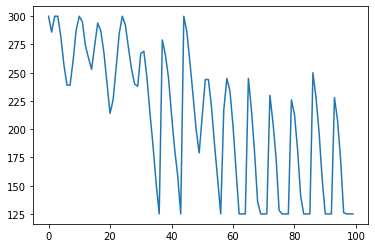

In [13]:
plt.figure()
plt.plot(day_arr)
print(day_arr)
print(np.min(day_arr))
print(np.max(day_arr))

[298. 271. 295. 298. 277. 248. 225. 250. 273. 294. 294. 289. 273. 246.
 254. 264. 289. 300. 271. 246. 224. 240. 269. 294. 295. 291. 266. 243.
 234. 256. 279. 287. 258. 233. 205. 186. 214. 239. 266. 242. 214. 191.
 199. 226. 255. 278. 256. 227. 200. 202. 224. 249. 260. 233. 208. 183.
 182. 211. 225. 213. 185. 156. 131. 127. 156. 181. 183. 164. 138. 127.
 125. 135. 162. 183. 164. 139. 129. 125. 138. 167. 194. 167. 143. 126.
 131. 155. 184. 211. 185. 156. 135. 127. 132. 158. 183. 158. 135. 138.
 126. 132.]


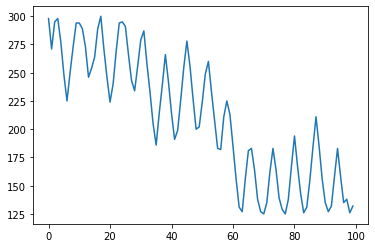

In [150]:
plt.figure()
plt.plot(day_arr)
print(day_arr)

In [11]:
x1=day_arr[:100]#[300,286,300,300,282,257,239,239,261,288,300,295,274,263,253,274,294,287,268,241,214,226,255,285,300,292,272,253,240,238,267,269,246,214,185,152,125,279,266,246,213,183,159,125,300,286,259,230,200,179,212,244,244,220,186,156,125,217,245,234,203,163,125,125,125,245,217,180,136,125,125,125,230,206,175,128,125,125,125,226,213,182,141,125,125,125,250,228,197,156,125,125,125,228,208,173,126,125,125,125] #day_arr #[300,287,300,298,282,259,244,246,268,293,300,300,279,264,250,269,292,284,266,240,215,229,256,282,300,287,269,254,245,242,270,271,250,218,191,163,194,229,249,233,203,174,180,208,245,262,242,215,189,172,208,242,246,222,185,153,125,211,241,230,200,159,125,125,125,249,220,183,139,125,125,125,231,210,177,131,125,127,125,225,212,182,140,125,125,125,253,229,197,156,125,125,125,229,208,173,127,125,125,125]
x2=optimal_day_arr[:100] # 0 
plt.figure(figsize=(16,8))
plt.plot(x1)
plt.plot(x2)
#plt.plot(np.array(x1)-np.array(x2))
plt.legend(["x1","x2"])

NameError: name 'optimal_day_arr' is not defined

In [18]:
min_peaks = [1,  6, 14, 17, 20, 29, 35, 41, 49, 56, 62, 64, 70, 73, 76, 78, 83, 91]
max_peaks = [11, 16, 18, 24, 31, 39, 45, 51, 58, 63, 65, 72, 74, 77, 80, 86, 93]
find_peaks(-day_arr)
#min_peaks = [2, 7, 20, ]

(array([ 1,  6, 14, 17, 20, 29, 35, 41, 49, 56, 62, 64, 70, 73, 76, 78, 83,
        91]), {})

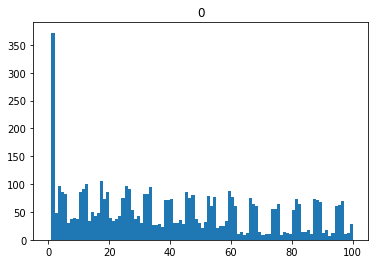

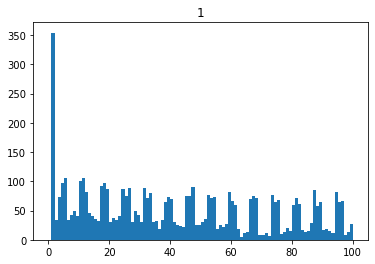

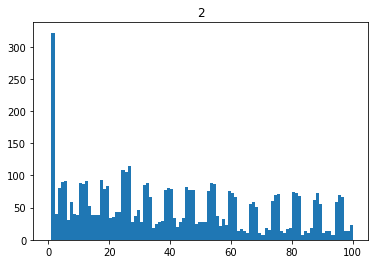

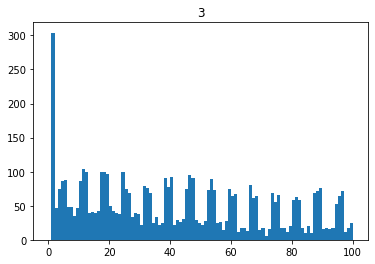

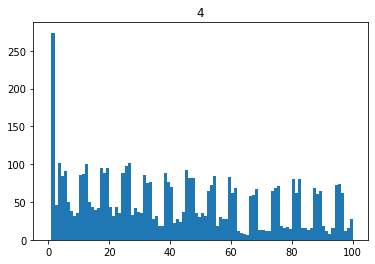

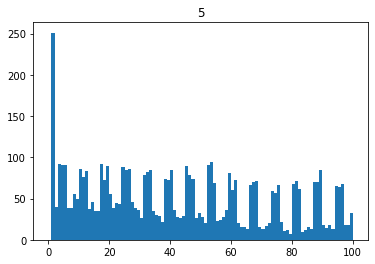

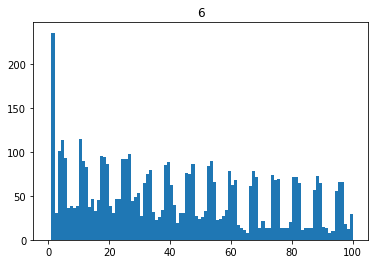

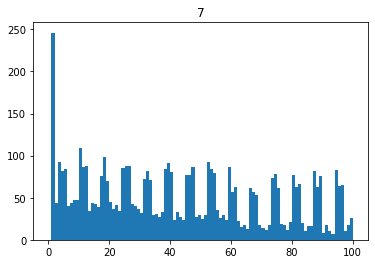

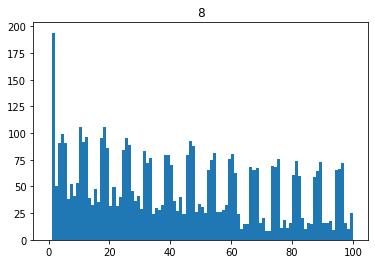

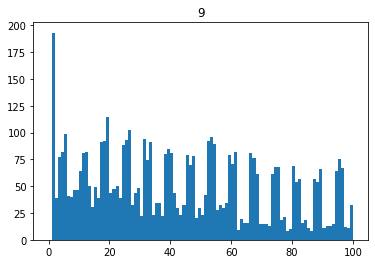

In [219]:
for i in range(10):
    plt.figure()
    plt.title(str(i))
    plt.hist(data["choice_" + str(i)],bins=range(100+1))

In [227]:
day_arr1 = np.array(range(101))
day_arr1[:100] = day_arr
day_arr1[100] = day_arr1[99]

In [228]:
[(day_arr1[i], abs(day_arr1[i] - day_arr1[i+1])) for i in range(100)]

[(299, 10),
 (289, 11),
 (300, 0),
 (300, 17),
 (283, 26),
 (257, 8),
 (249, 0),
 (249, 25),
 (274, 24),
 (298, 2),
 (300, 4),
 (296, 23),
 (273, 13),
 (260, 7),
 (253, 17),
 (270, 24),
 (294, 1),
 (293, 17),
 (276, 26),
 (250, 26),
 (224, 12),
 (236, 27),
 (263, 28),
 (291, 8),
 (299, 2),
 (297, 19),
 (278, 14),
 (264, 15),
 (249, 7),
 (242, 29),
 (271, 2),
 (273, 25),
 (248, 34),
 (214, 25),
 (189, 26),
 (163, 35),
 (198, 36),
 (234, 22),
 (256, 18),
 (238, 30),
 (208, 31),
 (177, 7),
 (170, 30),
 (200, 38),
 (238, 22),
 (260, 13),
 (247, 29),
 (218, 26),
 (192, 15),
 (177, 38),
 (215, 34),
 (249, 9),
 (240, 22),
 (218, 36),
 (182, 30),
 (152, 27),
 (125, 86),
 (211, 32),
 (243, 12),
 (231, 32),
 (199, 40),
 (159, 34),
 (125, 0),
 (125, 0),
 (125, 110),
 (235, 29),
 (206, 36),
 (170, 44),
 (126, 1),
 (125, 0),
 (125, 0),
 (125, 104),
 (229, 22),
 (207, 34),
 (173, 46),
 (127, 2),
 (125, 0),
 (125, 0),
 (125, 109),
 (234, 15),
 (219, 34),
 (185, 45),
 (140, 15),
 (125, 1),
 (126, 0),


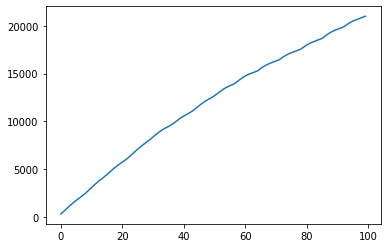

In [120]:
plt.plot([np.sum(day_arr[:i+1]) for i in range(100)])

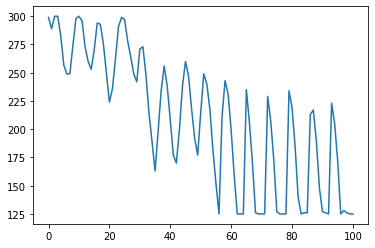

In [230]:
plt.plot(day_arr1)

In [12]:
lst = []
lst1 = []
for i in range(submission.shape[0]):
    assigned_day = submission.iloc[i]['assigned_day']
    picked_idx = -1
    for pick in range(10):
        choice_day = data.iloc[i][f'choice_{pick}']
        if assigned_day == choice_day:
            picked_idx = pick
            break
            
    d = picked_idx
    penalty = 0
    n = data.iloc[i]['n_people']
    if d == 0:
        penalty += 0
    elif d == 1:
        penalty += 50
    elif d == 2:
        penalty += 50 + 9 * n
    elif d == 3:
        penalty += 100 + 9 * n
    elif d == 4:
        penalty += 200 + 9 * n
    elif d == 5:
        penalty += 200 + 18 * n
    elif d == 6:
        penalty += 300 + 18 * n
    elif d == 7:
        penalty += 300 + 36 * n
    elif d == 8:
        penalty += 400 + 36 * n
    elif d == 9:
        penalty += 500 + 36 * n + 199 * n
    else:
        penalty += 500 + 36 * n + 398 * n
        
    lst.append([picked_idx, penalty, assigned_day])
    for t in range(n):
        lst1.append([picked_idx, penalty, assigned_day])
lst = np.array(lst)
lst1 = np.array(lst1)

In [13]:
for i in range(-1,10):
    print(i, lst[lst[:,0]==i].shape[0], lst1[lst1[:,0]==i].shape[0], np.sum(lst[lst[:,0]==i,1]))

-1 0 0 0
0 4019 16140 0
1 737 3611 36850
2 201 1004 19086
3 39 217 5853
4 4 31 1079
5 0 0 0
6 0 0 0
7 0 0 0
8 0 0 0
9 0 0 0


In [14]:
print((np.sum(lst[:,1]), cost_function(best) - np.sum(lst[:,1]),))
#62868.000000 6020.043432

pref/acc: 62868/6020
(62868, 6020.043431948157)


In [106]:
choice0 = []
choice1 = []
for i in range(data.shape[0]):
    n = data.iloc[i]["n_people"]
    for j in range(n):
        choice0.append(data.iloc[i]["choice_0"])
        choice1.append(data.iloc[i]["choice_1"])

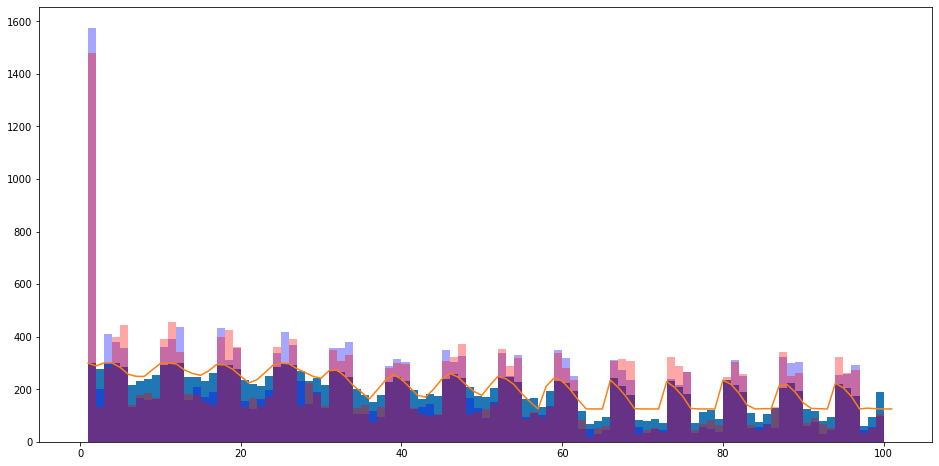

In [381]:
plt.figure(figsize=(16,8))
#plt.hist(lst1[lst1[:,0]==0][:,2],bins=range(0,101));
plt.hist(np.concatenate((lst1[lst1[:,0]==1][:,2], lst1[lst1[:,0]==0][:,2]), axis=0),bins=range(0,101));
#plt.hist(lst1[lst1[:,0]==2][:,2],bins=range(0,101));
#plt.hist(lst1[lst1[:,0]==3][:,2],bins=range(0,101));
plt.plot(range(1,102), day_arr1);
plt.hist(choice0,bins=range(0,101), color='b',alpha=0.35);
plt.hist(choice1,bins=range(0,101), color='r',alpha=0.35);
#plt.hist(choice1,bins=range(0,101), color='r', alpha=0.35);
#plt.legend(["ass","x0","x1","x2","cap0"]);

In [26]:
fpath = 'submission_lp_big1.csv'
optimal = pd.read_csv(fpath, index_col='family_id')

In [27]:
optimal_day_arr = np.zeros((1,101)).reshape(-1)
for i in range(data.shape[0]):
    rec = data.iloc[i]
    n_people = rec["n_people"]
    for key in ("choice_0", "choice_1", "choice_2", "choice_3", "choice_4"):
        optimal_day_arr[int(rec[key])-1] += optimal.iloc[i][key] * n_people

In [40]:
print(",".join(map(str, map(int, map(round, optimal_day_arr)))))

300,292,300,292,275,248,231,217,210,298,296,291,270,254,248,254,297,288,271,242,214,196,199,298,291,277,257,237,213,186,292,279,254,223,189,158,142,283,269,243,211,179,170,141,294,278,254,224,193,163,186,287,267,241,206,173,140,182,265,243,209,168,125,125,125,252,226,192,150,125,125,125,230,208,177,133,125,125,125,231,216,190,149,125,125,125,259,236,204,166,127,125,125,240,219,186,141,125,125,125,0


In [ ]:
img_dir = "/mnt/ssd/pku-autonom-driving/CenterNet/exp/ddd/default/debug/"
for item in sorted(os.listdir(img_dir))[:60]:
    img = cv2.imread(os.path.join(img_dir, item))
    plt.figure(figsize=(32,16))
    plt.title(item)
    plt.imshow(img)
    plt.show()

In [30]:
penLst = []

NACC = 300 - 125 + 1
for d0 in range(NACC):
    for d1 in range(NACC):
        nday0 = d0 + 125
        nday1 = d1 + 125
        
        penalty = (nday0 - 125.0) / 400.0 * (nday0 ** (0.5 + abs(nday0 - nday1) / 50.0))
        
        if penalty < 6500:
            penLst.append(penalty)

(array([15756.,  1589.,   898.,   616.,   470.,   376.,   319.,   264.,
          238.,   209.]),
 array([   0.        ,  649.99725028, 1299.99450055, 1949.99175083,
        2599.98900111, 3249.98625139, 3899.98350166, 4549.98075194,
        5199.97800222, 5849.9752525 , 6499.97250277]),
 <a list of 10 Patch objects>)

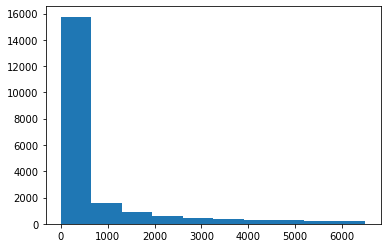

In [25]:
plt.hist(penLst)

In [26]:
NACC*NACC*100

3097600

In [22]:
np.sum(np.array(penLst) > 10000)

0

In [31]:
len(penLst) * 100

2073500

In [6]:
import pickle as pkl

In [7]:
var_found_values = pkl.load(open("sol6888806","rb"))

In [8]:
with open("submission_xpress.csv", "w") as fd:
    print("family_id,assigned_day", file=fd)
    for i in range(data.shape[0]):
        lst = [int(var) for var in var_found_values[i*5:(i+1)*5]]
        if 1 not in lst:
            print(i)
        print("%d,%d" % (i, data.iloc[i][lst.index(1)]), file=fd)